## Семинар 6 "Segmentation"

ФИО: Токаева Александра Александровна

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
#from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.nn import MSELoss
import torch

from PIL import Image
import skimage
from skimage import io


#from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
def process(dataset_path, mask_path=None, filter_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)
        
    if filter_path:
        filter_path = Path(filter_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
            
        if filter_path:
            filter_elem = io.imread(filter_path/(item['name'] + '_training_mask.gif'))
            item['filter'] = t.from_numpy(filter_elem)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/", 'train/mask/')

In [39]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform, filter_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.f_transform = filter_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        filt = data['filter'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        filt = self.f_transform(filt)
        return img, mask, filt
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584)),
    tsf.ToTensor(),
    tsf.ColorJitter(brightness=(1,1),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5]))
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
f_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565,584)),
    tsf.ToTensor()
])
train_dataset = Dataset(train_data,s_trans,t_trans,f_trans)
#dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([3, 565, 584])
torch.Size([1, 565, 584])


In [40]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

test_dataset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(test_dataset,batch_size=1)

In [41]:
test_dataset[0].shape

torch.Size([3, 565, 584])

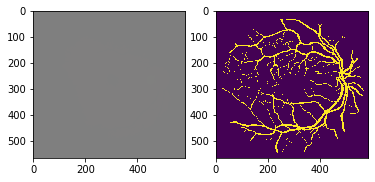

In [42]:
img,mask,filt = train_dataset[4]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [9]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=0):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

torch.Size([1, 128, 128])


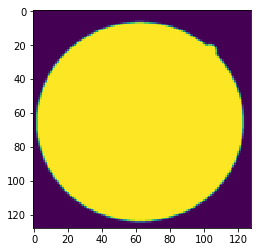

In [10]:
from torchvision import transforms
from PIL import Image
p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
m=p(Image.open("train/mask/21_training_mask.gif"))
print(m.shape)
plt.imshow(m[0])

In [11]:
# Попробуйте использовать различные функции потерь.
#from torchvision import transforms
#from PIL import Image
#p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
#m=p(Image.open("train/mask/21_training_mask.gif"))
#m=m[0]

def soft_dice_loss(inputs, targets, filters):
    m1 = inputs * filters
    m2 = targets * filters
    intersection = (m1 * m2)
    score = (2. * intersection.sum() + 1) / (m1.sum() + m2.sum() + 1)
    return 1 - score

In [18]:
from tqdm import tqdm
def train(network, epochs, learning_rate):
    loss = soft_dice_loss
    #loss=MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y, f in train_dataset:
                X=X.reshape(-1,3,565,584)
                network.zero_grad()
                prediction = network(X)
                y=y[0]
                prediction=prediction[0][0]
                #print(y.shape) 
                #print(prediction.shape)
                loss_batch = loss(prediction, y, f[0])
                #print("train_loss=",loss_batch)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                #accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            #train_accuracy_epochs.append(np.mean(accuracies))
            
            
            print('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], train_loss_epochs[-1]))
            
            
            plt.figure(figsize=(12, 5))
            #plt.subplot(1, 1, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0... (Train/Test) MSE: 0.609/0.609


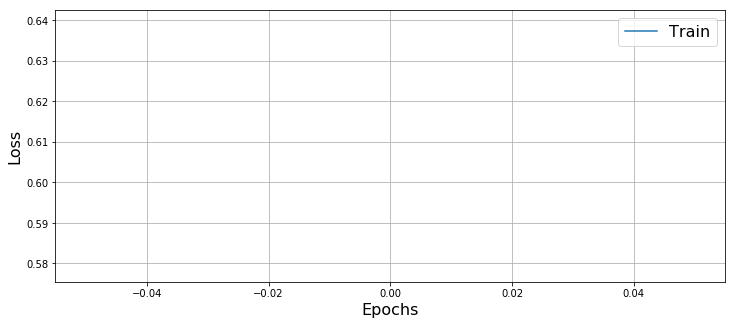

  0%|▍                                                                              | 1/200 [01:51<6:09:23, 111.38s/it]

Epoch 1... (Train/Test) MSE: 0.429/0.429


  1%|▊                                                                              | 2/200 [03:40<6:05:10, 110.66s/it]

Epoch 2... (Train/Test) MSE: 0.361/0.361


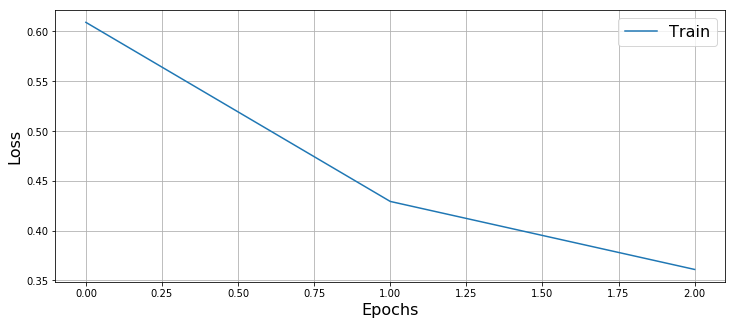

  2%|█▏                                                                             | 3/200 [05:29<6:01:49, 110.20s/it]

Epoch 3... (Train/Test) MSE: 0.313/0.313


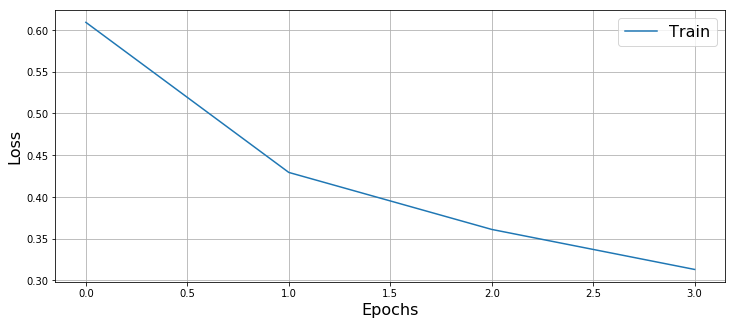

  2%|█▌                                                                             | 4/200 [07:18<5:58:54, 109.87s/it]

Epoch 4... (Train/Test) MSE: 0.289/0.289


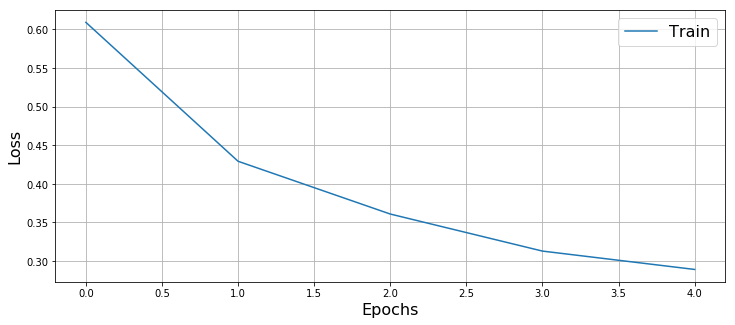

  2%|█▉                                                                             | 5/200 [09:07<5:55:52, 109.50s/it]

Epoch 5... (Train/Test) MSE: 0.277/0.277


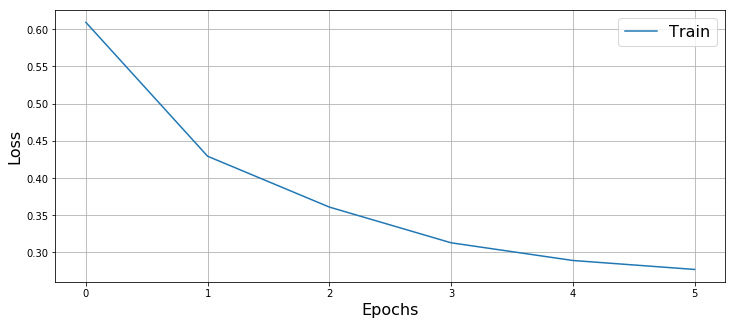

  3%|██▎                                                                            | 6/200 [10:55<5:53:13, 109.25s/it]

Epoch 6... (Train/Test) MSE: 0.270/0.270


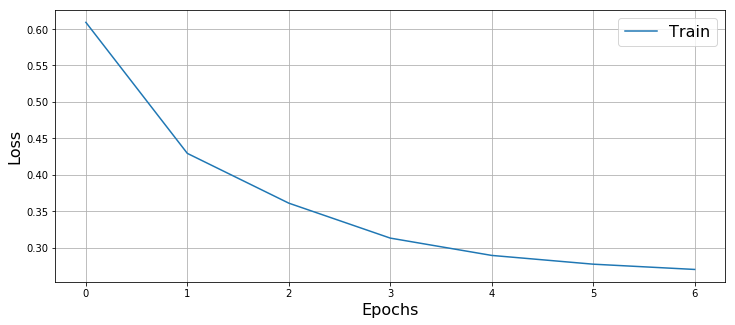

  4%|██▊                                                                            | 7/200 [12:44<5:50:27, 108.95s/it]

Epoch 7... (Train/Test) MSE: 0.261/0.261


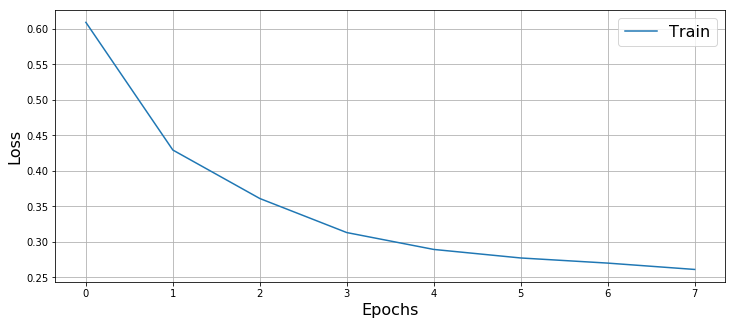

  4%|███▏                                                                           | 8/200 [14:32<5:48:01, 108.76s/it]

Epoch 8... (Train/Test) MSE: 0.257/0.257


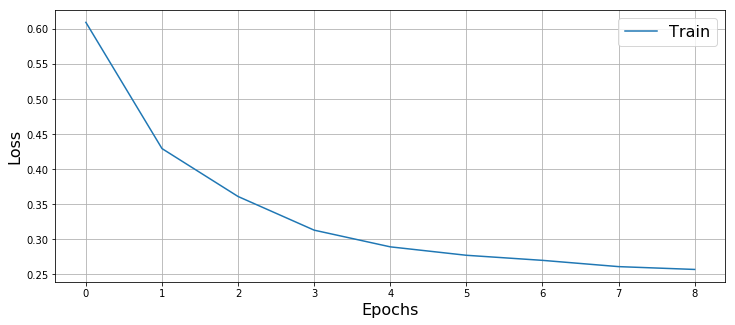

  4%|███▌                                                                           | 9/200 [16:20<5:45:46, 108.62s/it]

Epoch 9... (Train/Test) MSE: 0.256/0.256


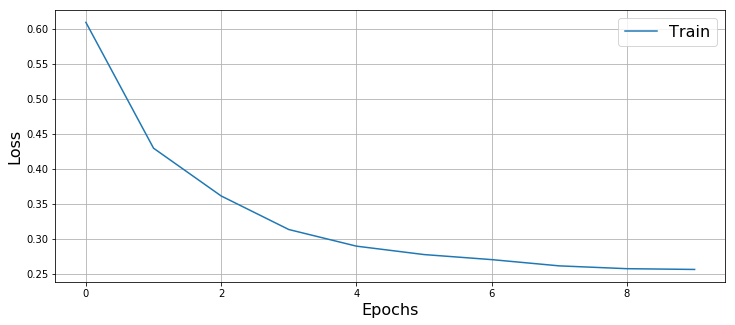

  5%|███▉                                                                          | 10/200 [18:08<5:43:27, 108.46s/it]

Epoch 10... (Train/Test) MSE: 0.252/0.252


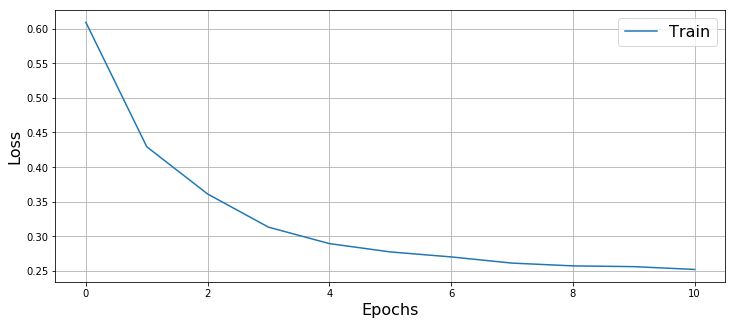

  6%|████▎                                                                         | 11/200 [19:56<5:41:14, 108.33s/it]

Epoch 11... (Train/Test) MSE: 0.251/0.251


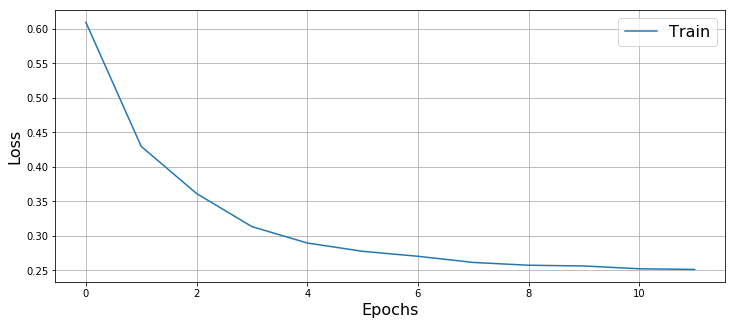

  6%|████▋                                                                         | 12/200 [21:45<5:39:31, 108.36s/it]

Epoch 12... (Train/Test) MSE: 0.247/0.247


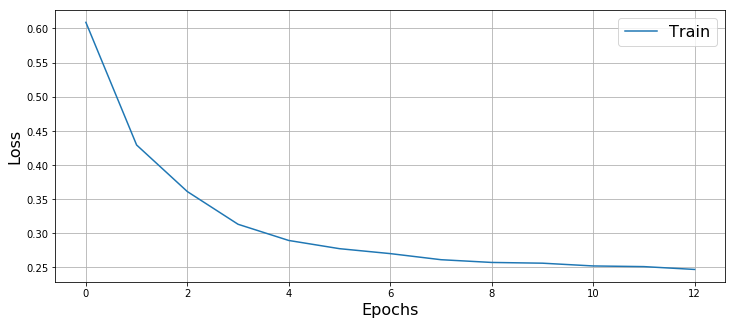

  6%|█████                                                                         | 13/200 [23:33<5:37:59, 108.45s/it]

Epoch 13... (Train/Test) MSE: 0.241/0.241


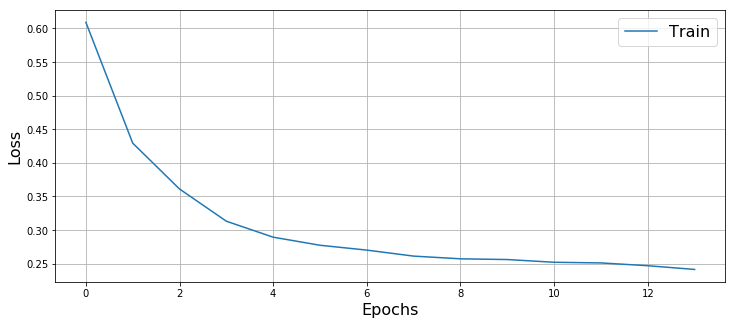

  7%|█████▍                                                                        | 14/200 [25:22<5:36:31, 108.56s/it]

Epoch 14... (Train/Test) MSE: 0.241/0.241


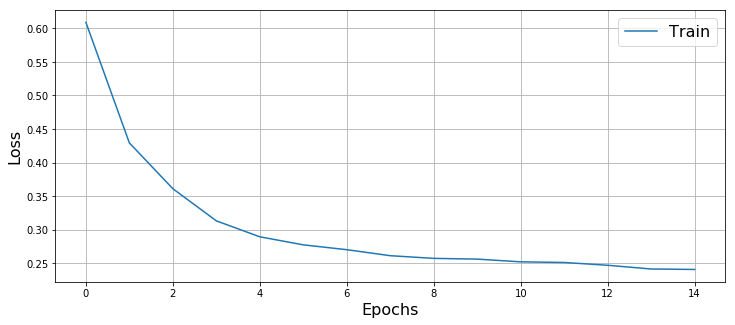

  8%|█████▊                                                                        | 15/200 [27:11<5:34:40, 108.54s/it]

Epoch 15... (Train/Test) MSE: 0.237/0.237


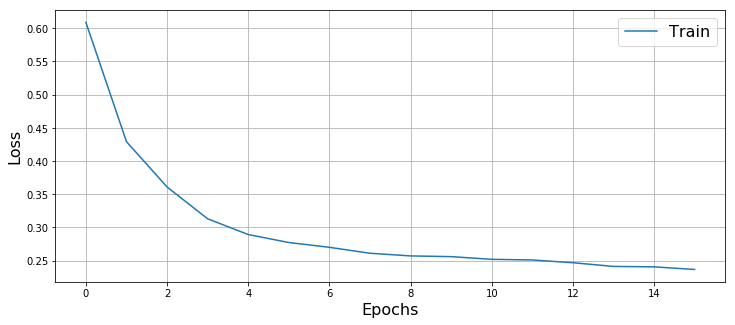

  8%|██████▏                                                                       | 16/200 [28:59<5:32:50, 108.53s/it]

Epoch 16... (Train/Test) MSE: 0.233/0.233


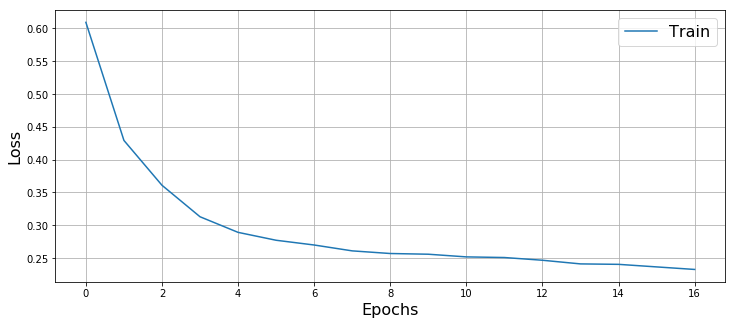

  8%|██████▋                                                                       | 17/200 [30:47<5:30:17, 108.29s/it]

Epoch 17... (Train/Test) MSE: 0.230/0.230


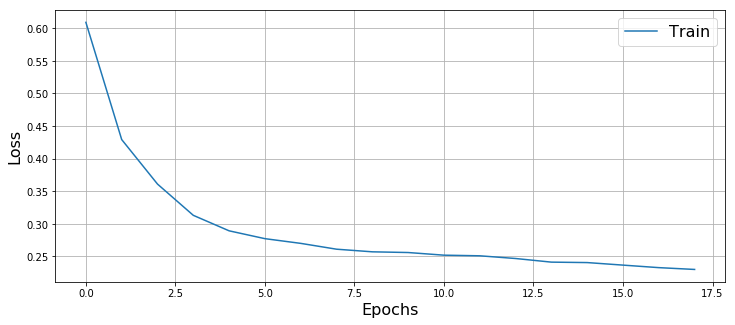

  9%|███████                                                                       | 18/200 [32:36<5:28:47, 108.39s/it]

Epoch 18... (Train/Test) MSE: 0.227/0.227


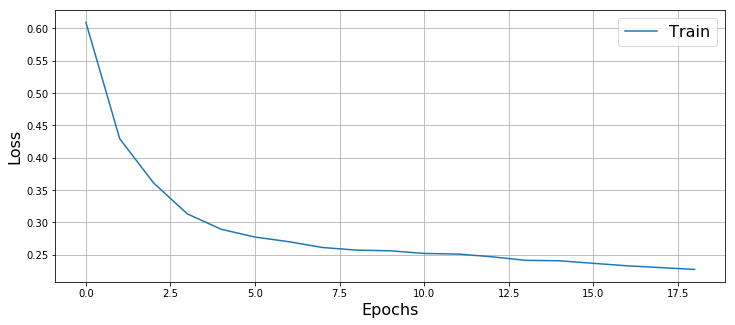

 10%|███████▍                                                                      | 19/200 [34:24<5:26:35, 108.26s/it]

Epoch 19... (Train/Test) MSE: 0.225/0.225


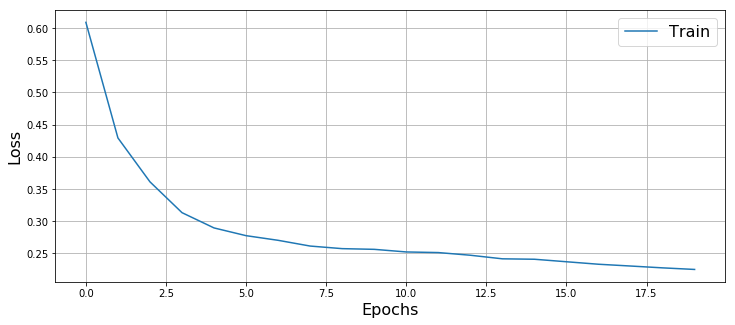

 10%|███████▊                                                                      | 20/200 [36:12<5:25:02, 108.35s/it]

Epoch 20... (Train/Test) MSE: 0.224/0.224


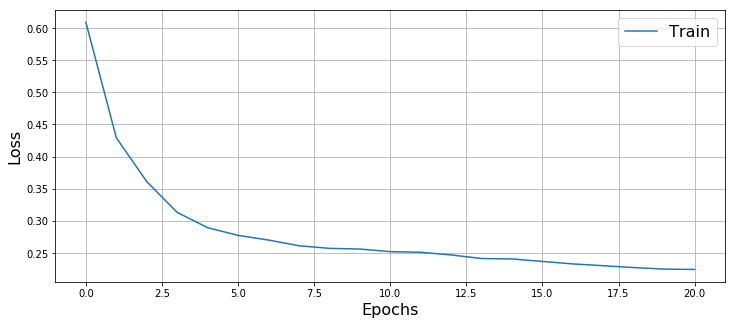

 10%|████████▏                                                                     | 21/200 [38:00<5:23:07, 108.31s/it]

Epoch 21... (Train/Test) MSE: 0.222/0.222


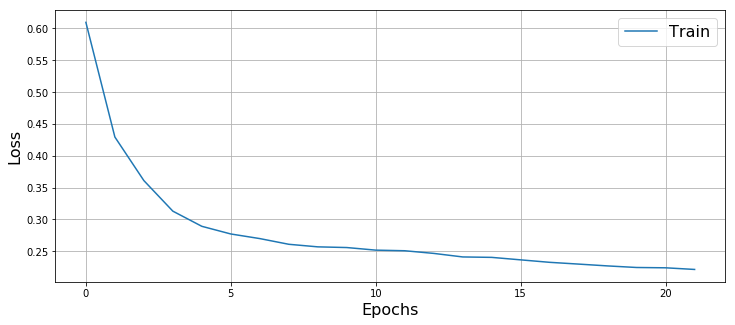

 11%|████████▌                                                                     | 22/200 [39:49<5:21:13, 108.28s/it]

Epoch 22... (Train/Test) MSE: 0.219/0.219


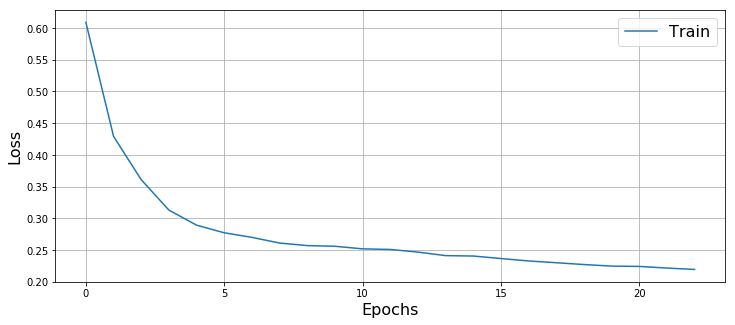

 12%|████████▉                                                                     | 23/200 [41:37<5:19:38, 108.35s/it]

Epoch 23... (Train/Test) MSE: 0.218/0.218


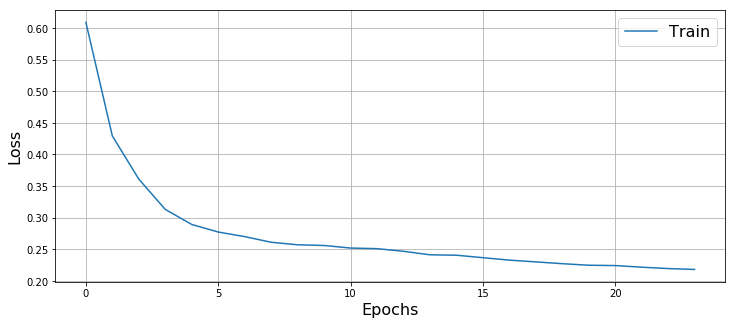

 12%|█████████▎                                                                    | 24/200 [43:25<5:17:47, 108.34s/it]

Epoch 24... (Train/Test) MSE: 0.217/0.217


 12%|█████████▊                                                                    | 25/200 [45:14<5:16:11, 108.41s/it]

Epoch 25... (Train/Test) MSE: 0.216/0.216


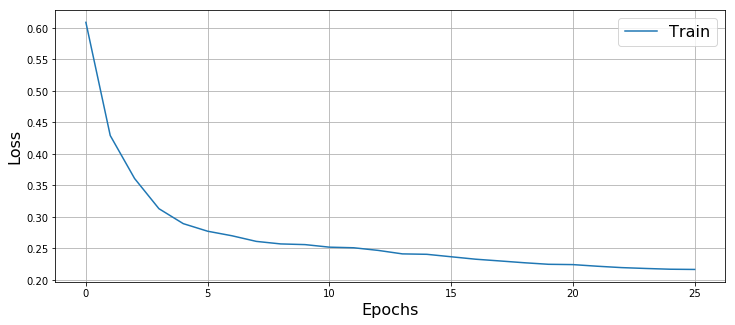

 13%|██████████▏                                                                   | 26/200 [47:02<5:14:17, 108.38s/it]

Epoch 26... (Train/Test) MSE: 0.218/0.218


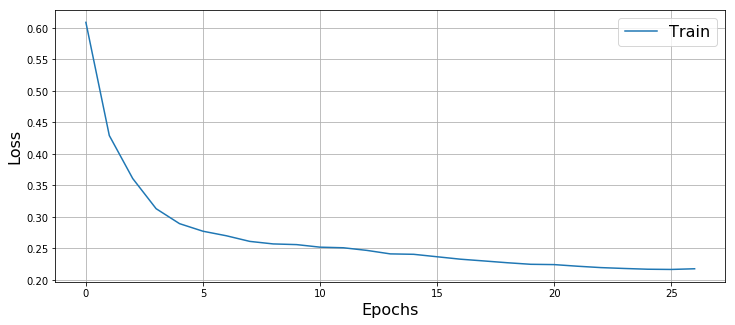

 14%|██████████▌                                                                   | 27/200 [48:51<5:12:27, 108.37s/it]

Epoch 27... (Train/Test) MSE: 0.219/0.219


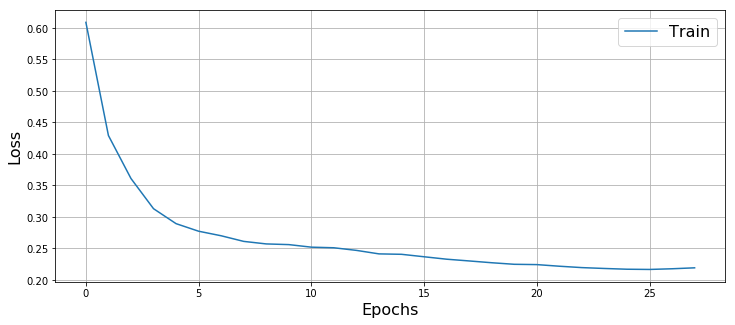

 14%|██████████▉                                                                   | 28/200 [50:39<5:10:37, 108.36s/it]

Epoch 28... (Train/Test) MSE: 0.216/0.216


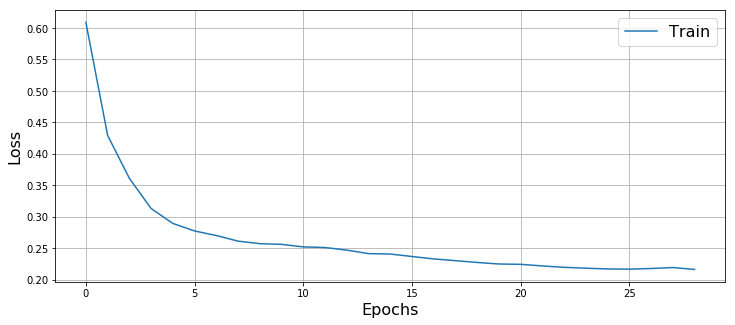

 14%|███████████▎                                                                  | 29/200 [52:27<5:08:50, 108.36s/it]

Epoch 29... (Train/Test) MSE: 0.215/0.215


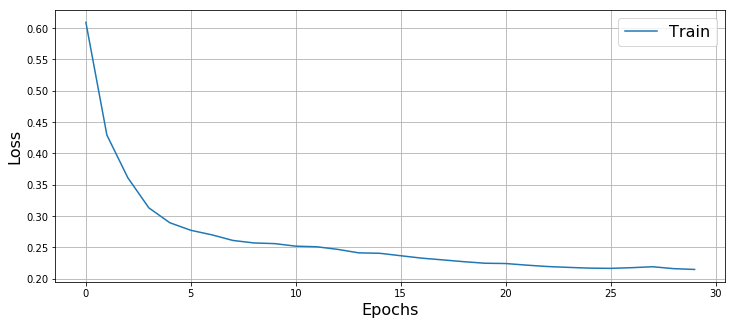

 15%|███████████▋                                                                  | 30/200 [54:16<5:07:12, 108.42s/it]

Epoch 30... (Train/Test) MSE: 0.213/0.213


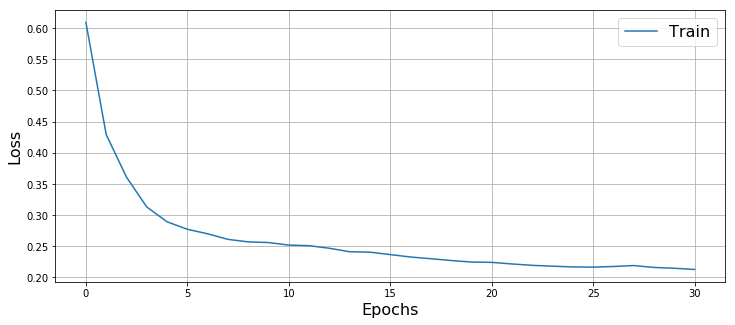

 16%|████████████                                                                  | 31/200 [56:26<5:24:05, 115.06s/it]

Epoch 31... (Train/Test) MSE: 0.213/0.213


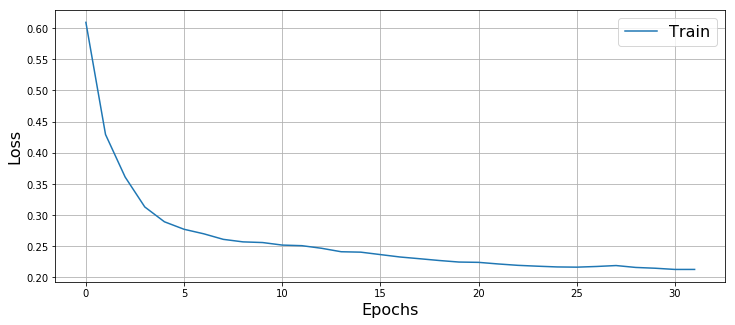

 16%|████████████▍                                                                 | 32/200 [59:33<6:22:08, 136.48s/it]

Epoch 32... (Train/Test) MSE: 0.209/0.209


 16%|████████████▌                                                               | 33/200 [1:02:39<7:01:41, 151.51s/it]

Epoch 33... (Train/Test) MSE: 0.209/0.209


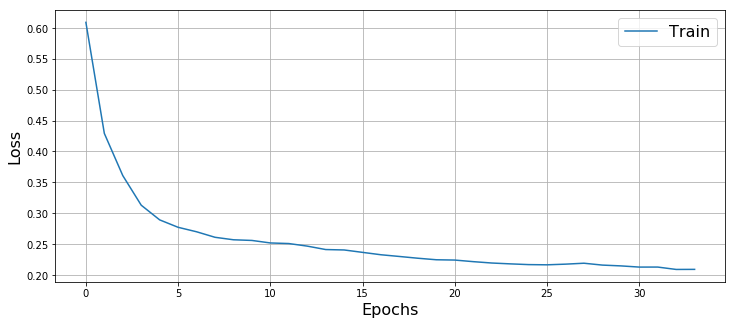

 17%|████████████▉                                                               | 34/200 [1:05:46<7:28:27, 162.10s/it]

Epoch 34... (Train/Test) MSE: 0.213/0.213


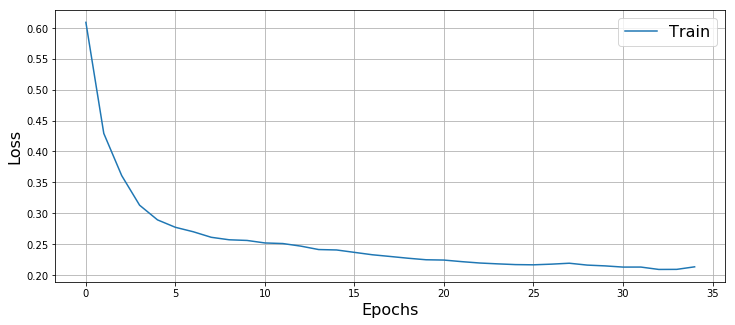

 18%|█████████████▎                                                              | 35/200 [1:08:53<7:45:58, 169.44s/it]

Epoch 35... (Train/Test) MSE: 0.209/0.209


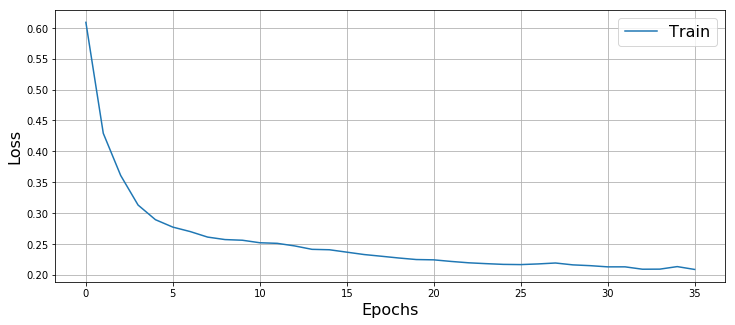

 18%|█████████████▋                                                              | 36/200 [1:12:00<7:57:15, 174.60s/it]

Epoch 36... (Train/Test) MSE: 0.209/0.209


 18%|██████████████                                                              | 37/200 [1:15:06<8:03:44, 178.06s/it]

Epoch 37... (Train/Test) MSE: 0.209/0.209


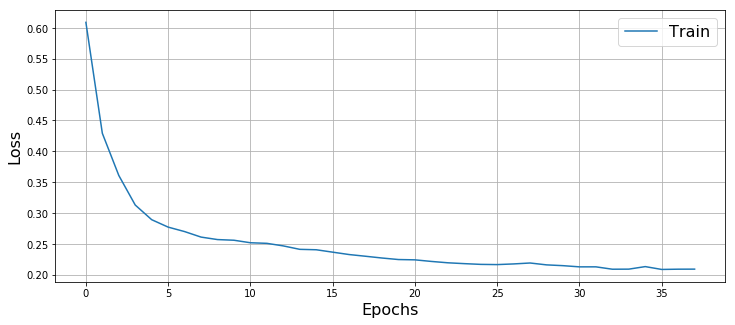

 19%|██████████████▍                                                             | 38/200 [1:17:15<7:20:57, 163.32s/it]

Epoch 38... (Train/Test) MSE: 0.208/0.208


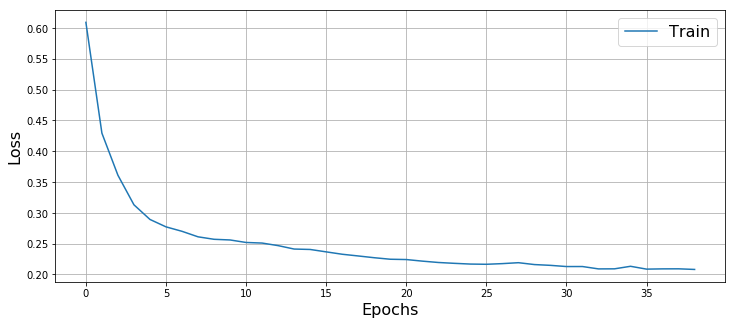

 20%|██████████████▊                                                             | 39/200 [1:19:00<6:31:23, 145.86s/it]

Epoch 39... (Train/Test) MSE: 0.206/0.206


 20%|███████████████▏                                                            | 40/200 [1:20:45<5:56:08, 133.55s/it]

Epoch 40... (Train/Test) MSE: 0.205/0.205


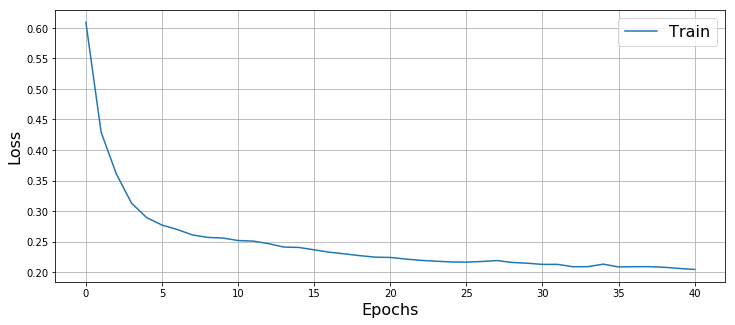

 20%|███████████████▌                                                            | 41/200 [1:22:30<5:31:33, 125.11s/it]

Epoch 41... (Train/Test) MSE: 0.205/0.205


 21%|███████████████▉                                                            | 42/200 [1:24:15<5:13:38, 119.11s/it]

Epoch 42... (Train/Test) MSE: 0.203/0.203


 22%|████████████████▎                                                           | 43/200 [1:26:00<5:00:51, 114.98s/it]

Epoch 43... (Train/Test) MSE: 0.200/0.200


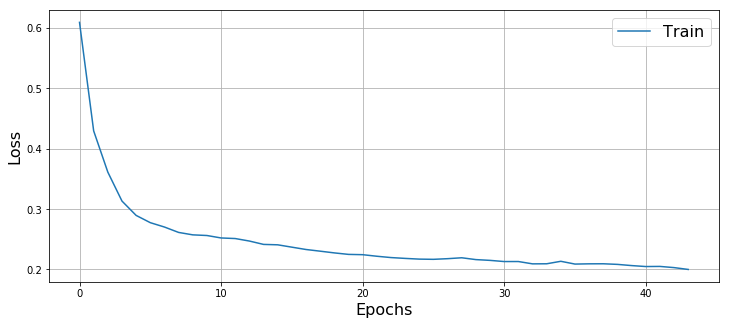

 22%|████████████████▋                                                           | 44/200 [1:27:46<4:51:21, 112.06s/it]

Epoch 44... (Train/Test) MSE: 0.201/0.201


 22%|█████████████████                                                           | 45/200 [1:29:30<4:43:53, 109.89s/it]

Epoch 45... (Train/Test) MSE: 0.200/0.200


 23%|█████████████████▍                                                          | 46/200 [1:31:15<4:38:09, 108.38s/it]

Epoch 46... (Train/Test) MSE: 0.201/0.201


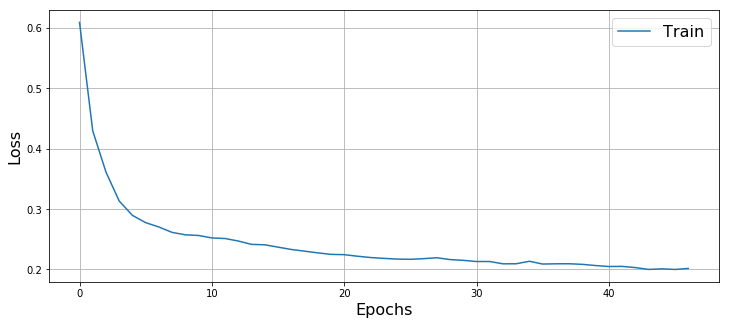

 24%|█████████████████▊                                                          | 47/200 [1:33:01<4:34:08, 107.51s/it]

Epoch 47... (Train/Test) MSE: 0.201/0.201


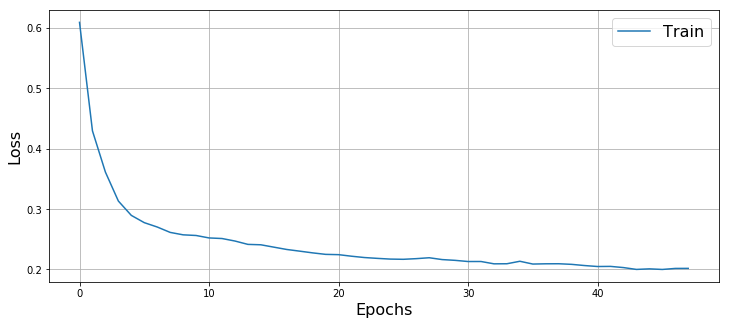

 24%|██████████████████▏                                                         | 48/200 [1:34:46<4:30:49, 106.90s/it]

Epoch 48... (Train/Test) MSE: 0.200/0.200


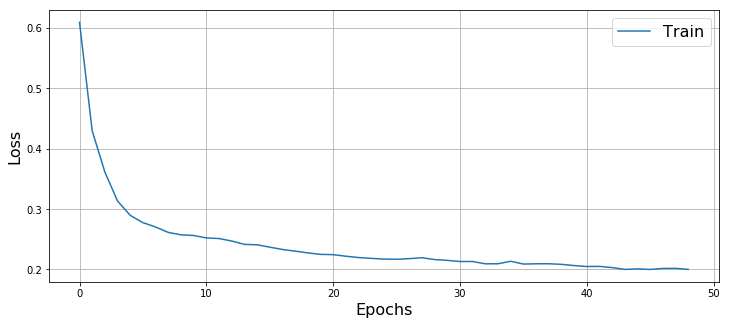

 24%|██████████████████▌                                                         | 49/200 [1:36:32<4:28:28, 106.68s/it]

Epoch 49... (Train/Test) MSE: 0.197/0.197


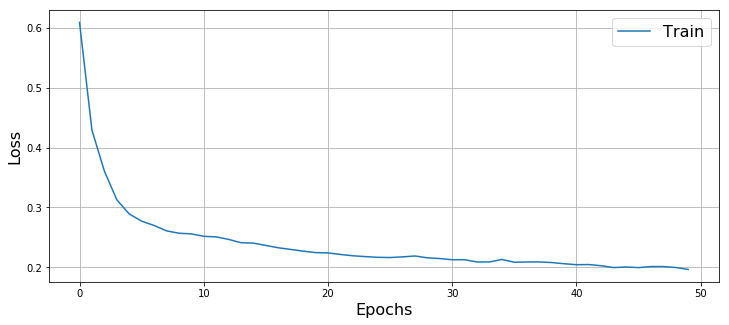

 25%|███████████████████                                                         | 50/200 [1:38:17<4:25:26, 106.18s/it]

Epoch 50... (Train/Test) MSE: 0.197/0.197


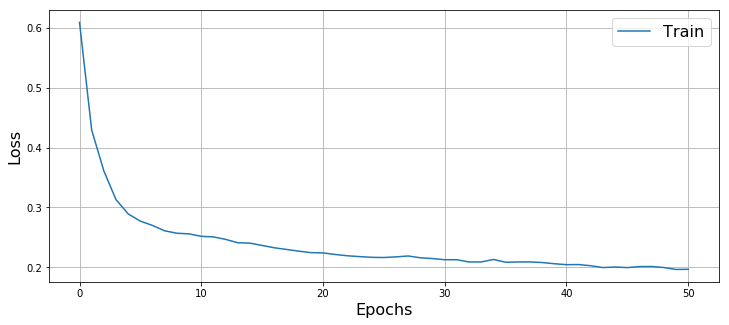

 26%|███████████████████▍                                                        | 51/200 [1:40:02<4:22:42, 105.79s/it]

Epoch 51... (Train/Test) MSE: 0.194/0.194


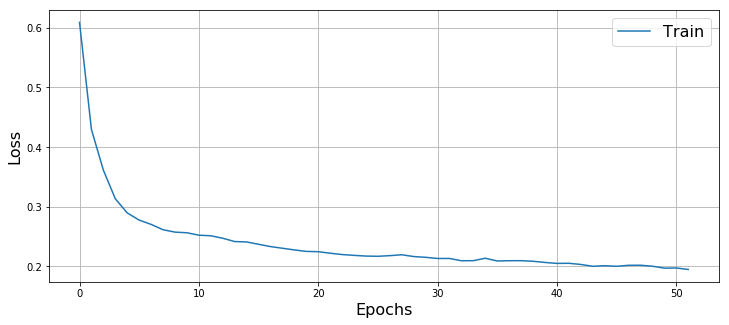

 26%|███████████████████▊                                                        | 52/200 [1:41:48<4:20:37, 105.66s/it]

Epoch 52... (Train/Test) MSE: 0.194/0.194


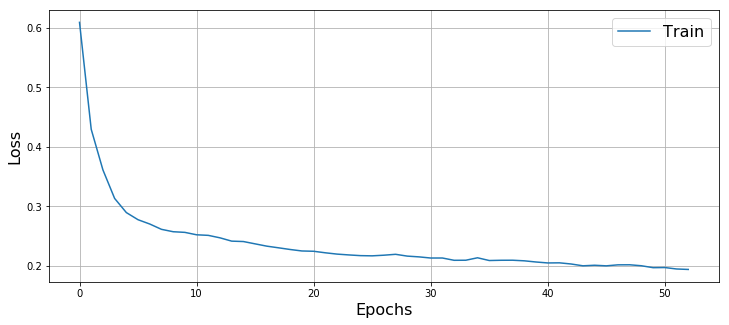

 26%|████████████████████▏                                                       | 53/200 [1:43:33<4:18:22, 105.46s/it]

Epoch 53... (Train/Test) MSE: 0.191/0.191


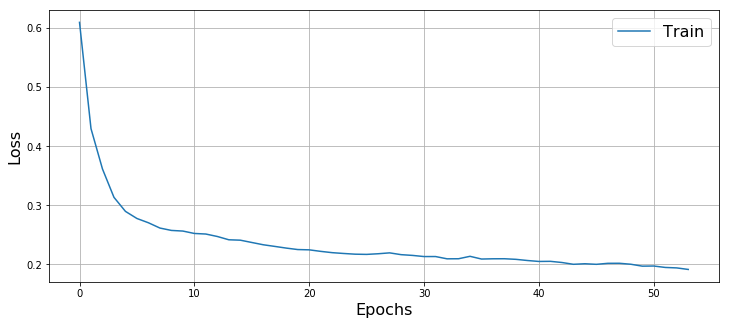

 27%|████████████████████▌                                                       | 54/200 [1:45:18<4:16:15, 105.31s/it]

Epoch 54... (Train/Test) MSE: 0.192/0.192


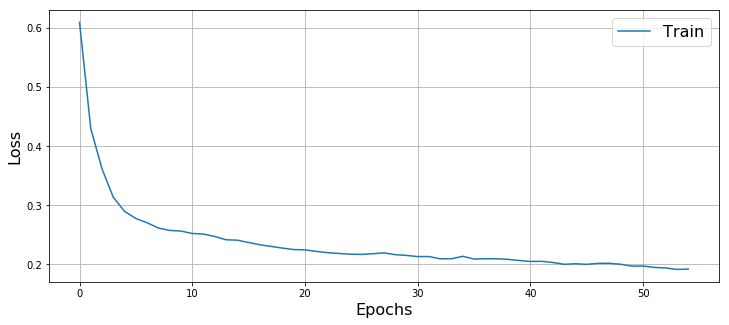

 28%|████████████████████▉                                                       | 55/200 [1:47:03<4:14:16, 105.21s/it]

Epoch 55... (Train/Test) MSE: 0.193/0.193


 28%|█████████████████████▎                                                      | 56/200 [1:48:47<4:12:06, 105.05s/it]

Epoch 56... (Train/Test) MSE: 0.195/0.195


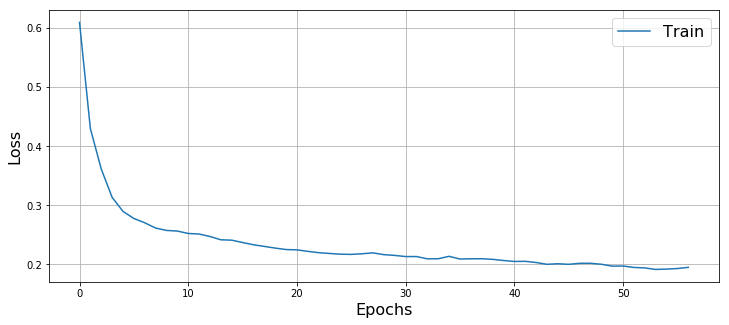

 28%|█████████████████████▋                                                      | 57/200 [1:50:32<4:10:20, 105.04s/it]

Epoch 57... (Train/Test) MSE: 0.192/0.192


 29%|██████████████████████                                                      | 58/200 [1:52:17<4:08:39, 105.07s/it]

Epoch 58... (Train/Test) MSE: 0.191/0.191


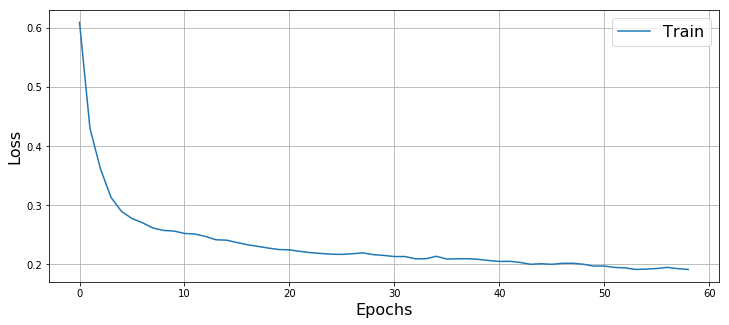

 30%|██████████████████████▍                                                     | 59/200 [1:54:02<4:06:49, 105.04s/it]

Epoch 59... (Train/Test) MSE: 0.191/0.191


 30%|██████████████████████▊                                                     | 60/200 [1:55:47<4:05:04, 105.03s/it]

Epoch 60... (Train/Test) MSE: 0.189/0.189


 30%|███████████████████████▏                                                    | 61/200 [1:57:32<4:03:20, 105.04s/it]

Epoch 61... (Train/Test) MSE: 0.189/0.189


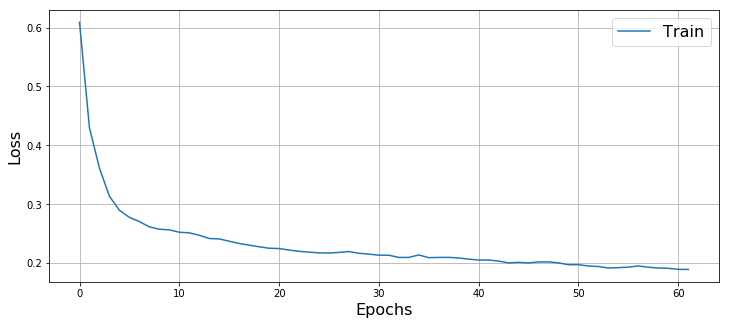

 31%|███████████████████████▌                                                    | 62/200 [1:59:18<4:01:42, 105.09s/it]

Epoch 62... (Train/Test) MSE: 0.189/0.189


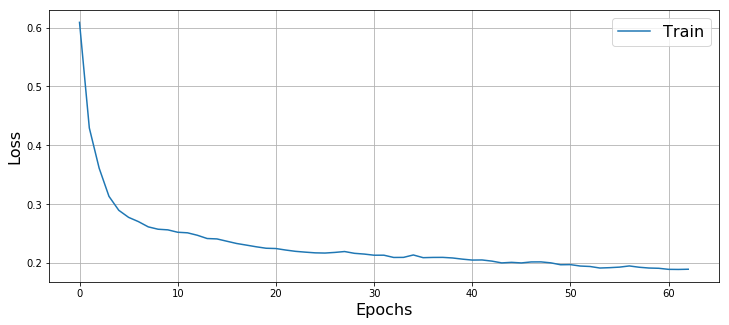

 32%|███████████████████████▉                                                    | 63/200 [2:01:03<3:59:52, 105.05s/it]

Epoch 63... (Train/Test) MSE: 0.188/0.188


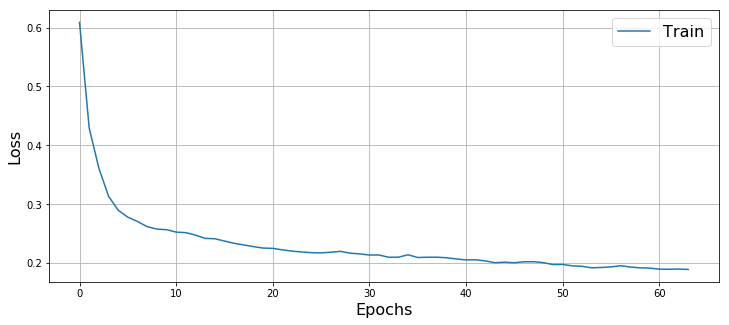

 32%|████████████████████████▎                                                   | 64/200 [2:02:48<3:58:13, 105.10s/it]

Epoch 64... (Train/Test) MSE: 0.186/0.186


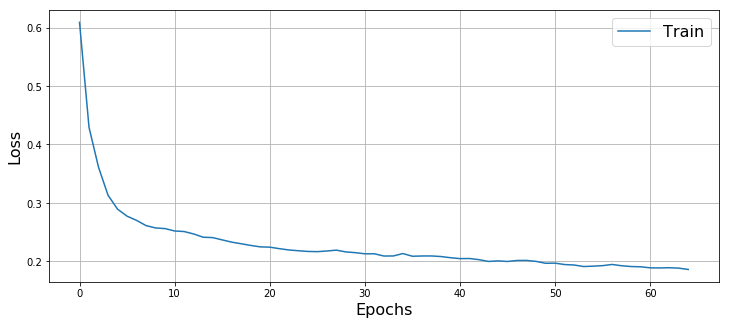

 32%|████████████████████████▋                                                   | 65/200 [2:04:33<3:56:23, 105.06s/it]

Epoch 65... (Train/Test) MSE: 0.184/0.184


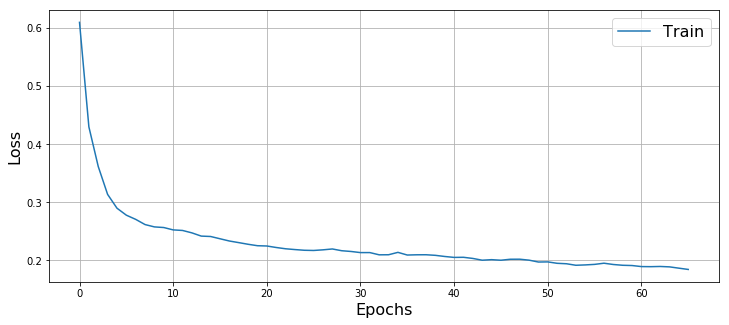

 33%|█████████████████████████                                                   | 66/200 [2:06:18<3:54:34, 105.03s/it]

Epoch 66... (Train/Test) MSE: 0.183/0.183


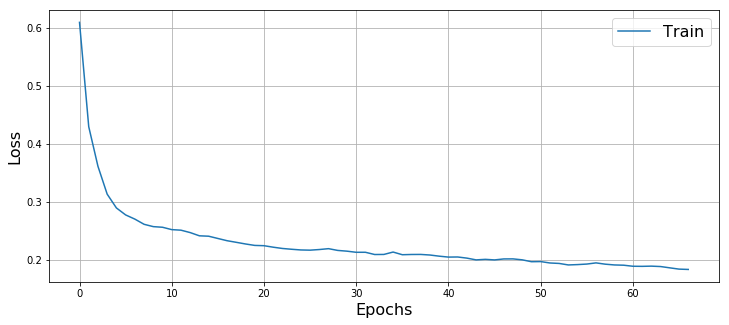

 34%|█████████████████████████▍                                                  | 67/200 [2:08:02<3:52:28, 104.88s/it]

Epoch 67... (Train/Test) MSE: 0.182/0.182


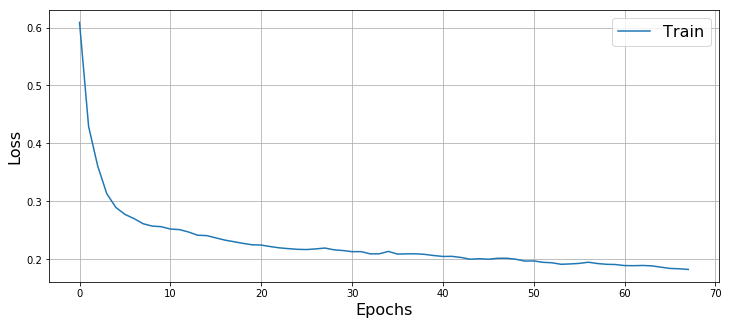

 34%|█████████████████████████▊                                                  | 68/200 [2:09:47<3:50:34, 104.81s/it]

Epoch 68... (Train/Test) MSE: 0.182/0.182


 34%|██████████████████████████▏                                                 | 69/200 [2:11:32<3:48:59, 104.88s/it]

Epoch 69... (Train/Test) MSE: 0.181/0.181


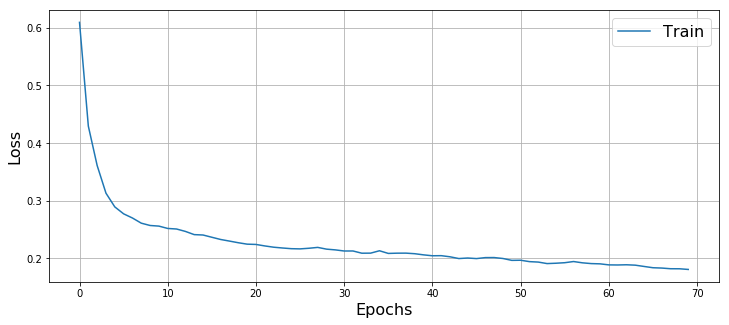

 35%|██████████████████████████▌                                                 | 70/200 [2:13:17<3:47:06, 104.82s/it]

Epoch 70... (Train/Test) MSE: 0.181/0.181


 36%|██████████████████████████▉                                                 | 71/200 [2:15:02<3:45:26, 104.85s/it]

Epoch 71... (Train/Test) MSE: 0.181/0.181


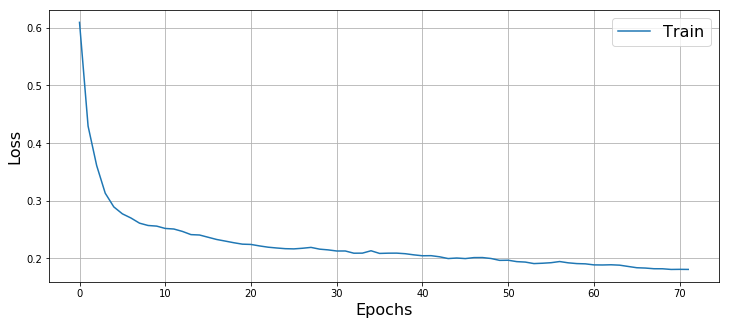

 36%|███████████████████████████▎                                                | 72/200 [2:16:46<3:43:34, 104.80s/it]

Epoch 72... (Train/Test) MSE: 0.191/0.191


 36%|███████████████████████████▋                                                | 73/200 [2:18:31<3:41:54, 104.84s/it]

Epoch 73... (Train/Test) MSE: 0.189/0.189


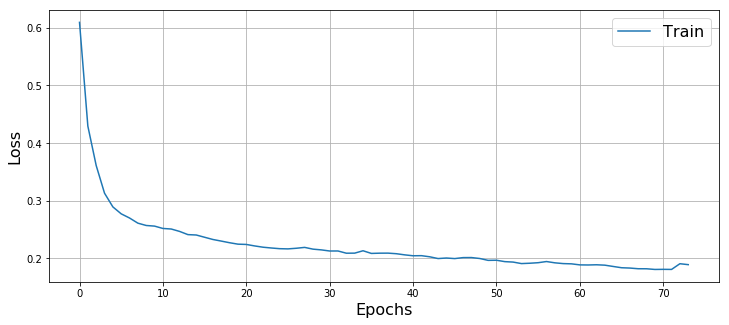

 37%|████████████████████████████                                                | 74/200 [2:20:16<3:40:08, 104.83s/it]

Epoch 74... (Train/Test) MSE: 0.187/0.187


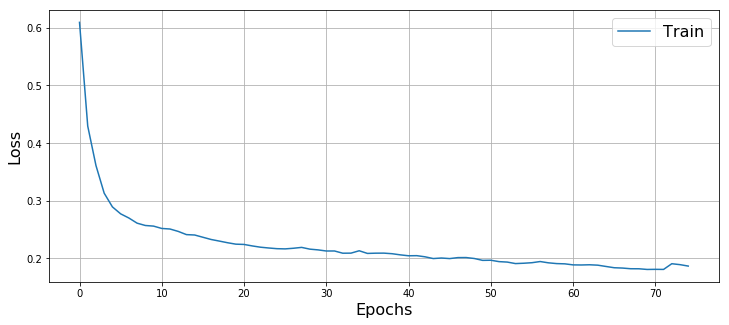

 38%|████████████████████████████▌                                               | 75/200 [2:22:01<3:38:20, 104.81s/it]

Epoch 75... (Train/Test) MSE: 0.182/0.182


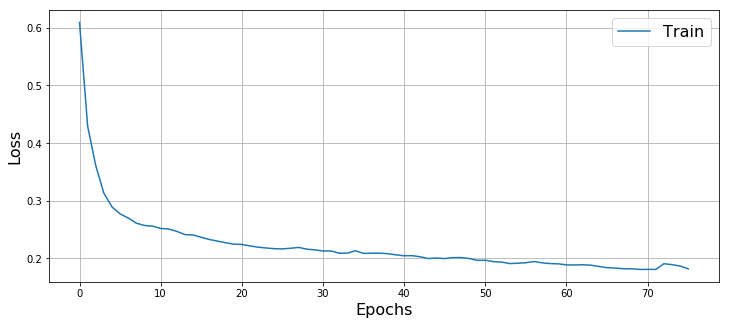

 38%|████████████████████████████▉                                               | 76/200 [2:23:46<3:36:53, 104.94s/it]

Epoch 76... (Train/Test) MSE: 0.178/0.178


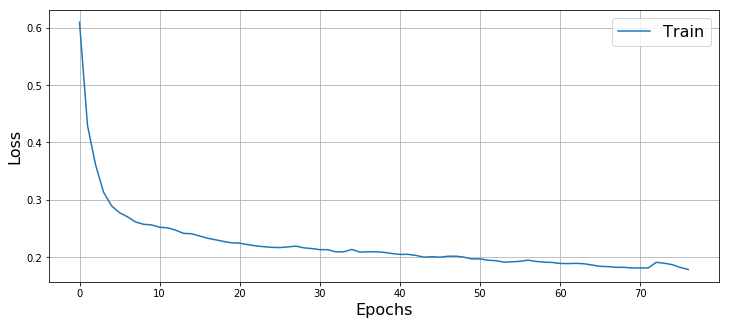

 38%|█████████████████████████████▎                                              | 77/200 [2:25:31<3:34:57, 104.86s/it]

Epoch 77... (Train/Test) MSE: 0.177/0.177


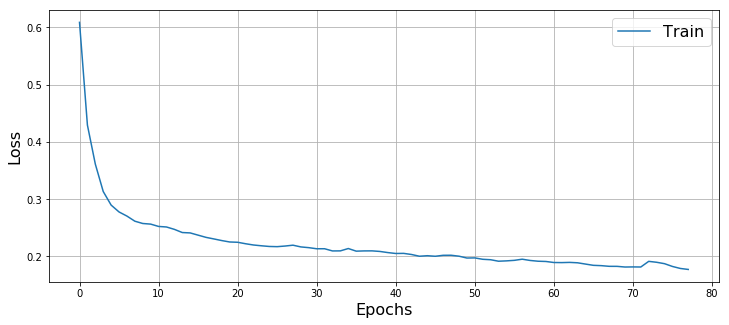

 39%|█████████████████████████████▋                                              | 78/200 [2:27:16<3:33:23, 104.95s/it]

Epoch 78... (Train/Test) MSE: 0.175/0.175


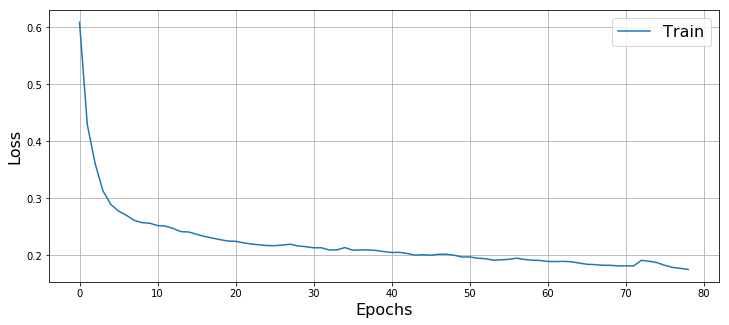

 40%|██████████████████████████████                                              | 79/200 [2:29:01<3:31:42, 104.98s/it]

Epoch 79... (Train/Test) MSE: 0.173/0.173


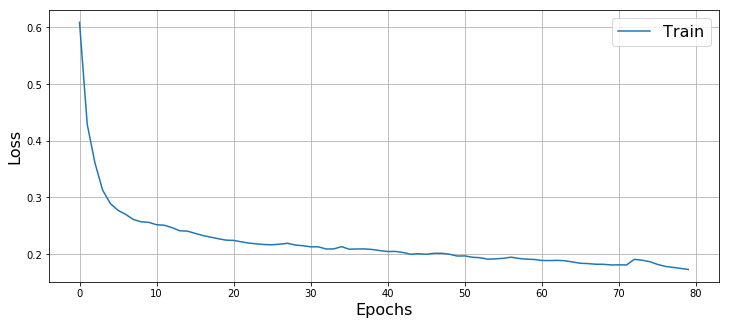

 40%|██████████████████████████████▍                                             | 80/200 [2:30:46<3:30:04, 105.04s/it]

Epoch 80... (Train/Test) MSE: 0.173/0.173


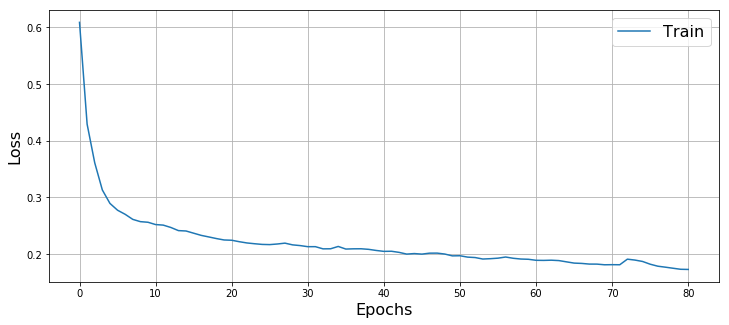

 40%|██████████████████████████████▊                                             | 81/200 [2:32:31<3:28:05, 104.92s/it]

Epoch 81... (Train/Test) MSE: 0.175/0.175


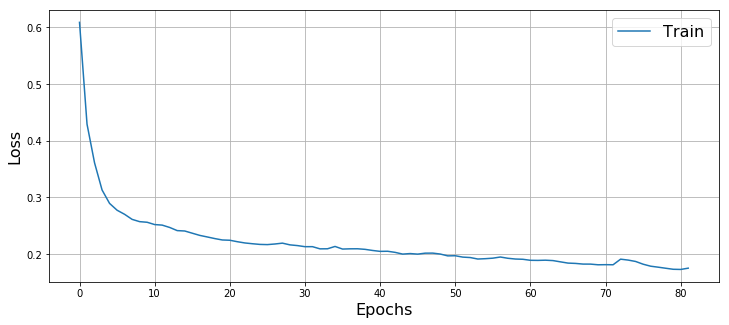

 41%|███████████████████████████████▏                                            | 82/200 [2:34:16<3:26:18, 104.90s/it]

Epoch 82... (Train/Test) MSE: 0.176/0.176


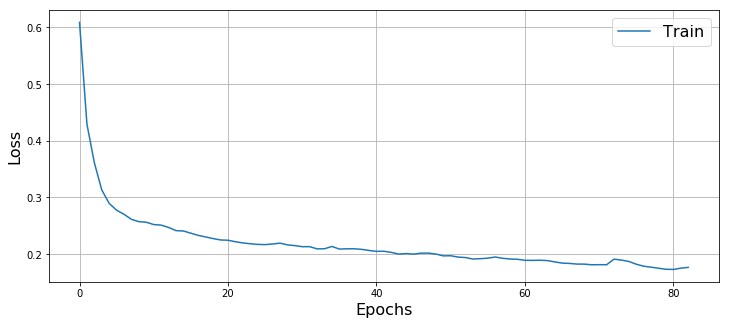

 42%|███████████████████████████████▌                                            | 83/200 [2:36:01<3:24:37, 104.93s/it]

Epoch 83... (Train/Test) MSE: 0.175/0.175


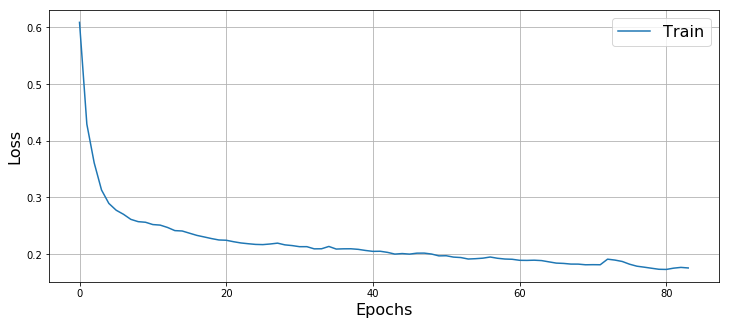

 42%|███████████████████████████████▉                                            | 84/200 [2:37:46<3:22:56, 104.97s/it]

Epoch 84... (Train/Test) MSE: 0.173/0.173


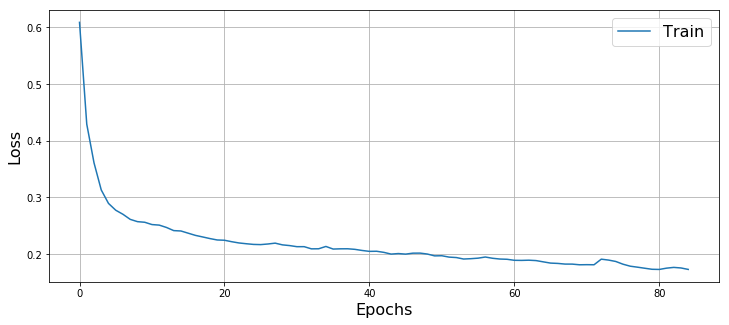

 42%|████████████████████████████████▎                                           | 85/200 [2:39:31<3:21:08, 104.95s/it]

Epoch 85... (Train/Test) MSE: 0.171/0.171


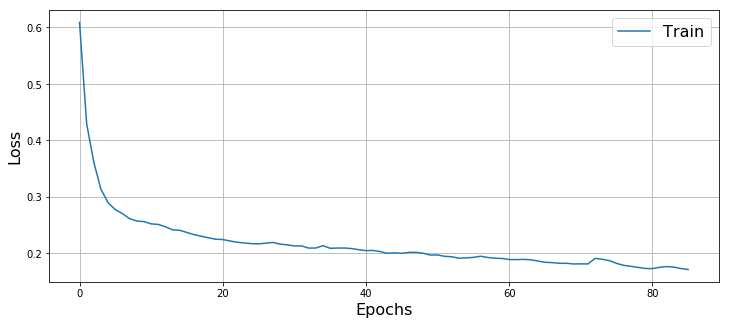

 43%|████████████████████████████████▋                                           | 86/200 [2:41:15<3:19:14, 104.86s/it]

Epoch 86... (Train/Test) MSE: 0.170/0.170


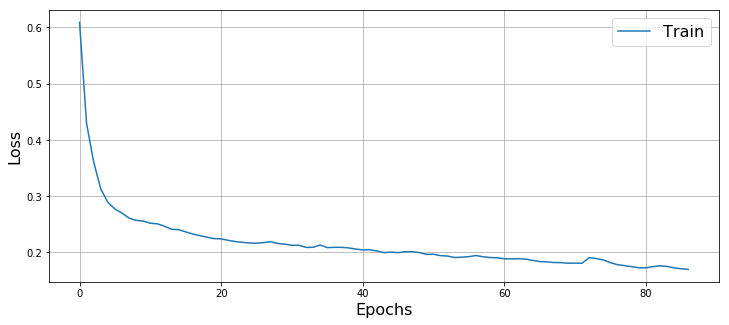

 44%|█████████████████████████████████                                           | 87/200 [2:43:00<3:17:36, 104.93s/it]

Epoch 87... (Train/Test) MSE: 0.170/0.170


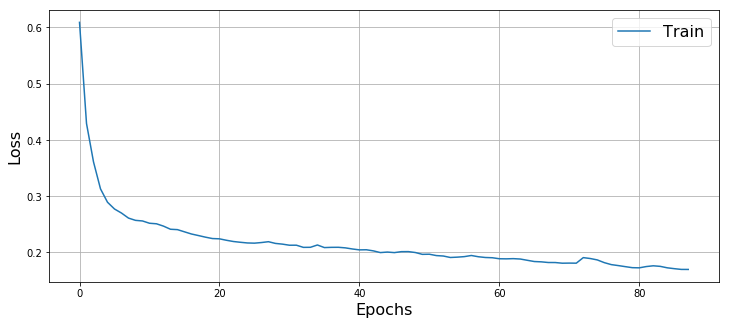

 44%|█████████████████████████████████▍                                          | 88/200 [2:44:45<3:15:43, 104.85s/it]

Epoch 88... (Train/Test) MSE: 0.169/0.169


 44%|█████████████████████████████████▊                                          | 89/200 [2:46:30<3:14:04, 104.91s/it]

Epoch 89... (Train/Test) MSE: 0.168/0.168


 45%|██████████████████████████████████▏                                         | 90/200 [2:48:15<3:12:13, 104.85s/it]

Epoch 90... (Train/Test) MSE: 0.167/0.167


 46%|██████████████████████████████████▌                                         | 91/200 [2:49:59<3:10:22, 104.79s/it]

Epoch 91... (Train/Test) MSE: 0.168/0.168


 46%|██████████████████████████████████▉                                         | 92/200 [2:51:44<3:08:42, 104.84s/it]

Epoch 92... (Train/Test) MSE: 0.167/0.167


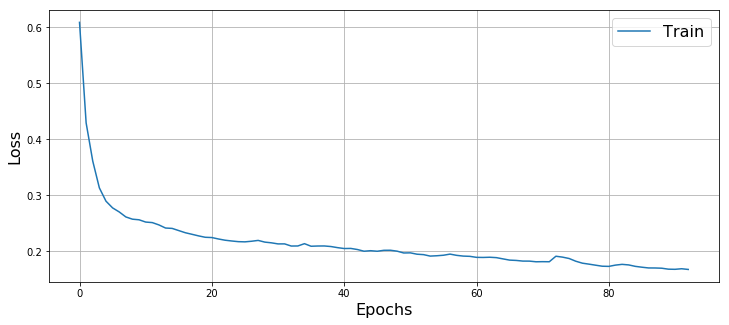

 46%|███████████████████████████████████▎                                        | 93/200 [2:53:29<3:06:55, 104.81s/it]

Epoch 93... (Train/Test) MSE: 0.166/0.166


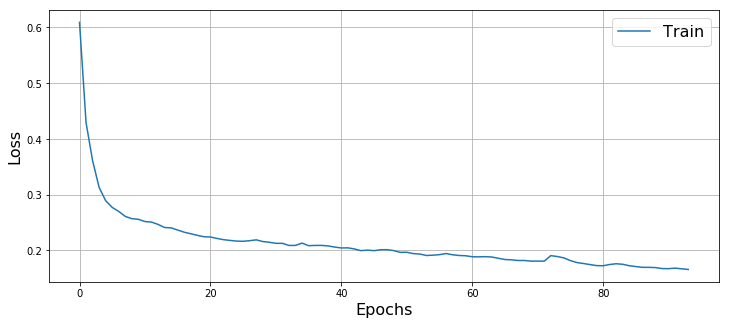

 47%|███████████████████████████████████▋                                        | 94/200 [2:55:14<3:05:08, 104.80s/it]

Epoch 94... (Train/Test) MSE: 0.165/0.165


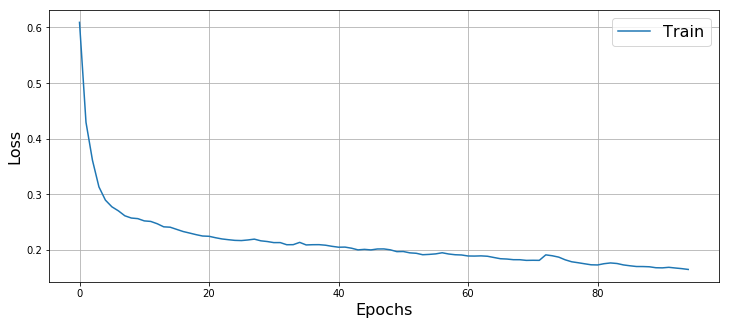

 48%|████████████████████████████████████                                        | 95/200 [2:56:59<3:03:19, 104.76s/it]

Epoch 95... (Train/Test) MSE: 0.164/0.164


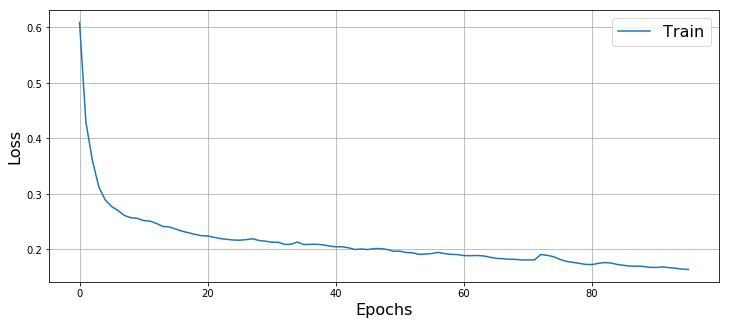

 48%|████████████████████████████████████▍                                       | 96/200 [2:58:43<3:01:41, 104.82s/it]

Epoch 96... (Train/Test) MSE: 0.163/0.163


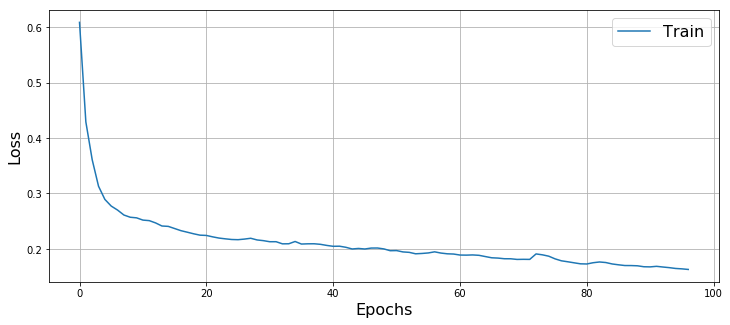

 48%|████████████████████████████████████▊                                       | 97/200 [3:00:28<2:59:48, 104.74s/it]

Epoch 97... (Train/Test) MSE: 0.164/0.164


 49%|█████████████████████████████████████▏                                      | 98/200 [3:02:13<2:57:56, 104.67s/it]

Epoch 98... (Train/Test) MSE: 0.163/0.163


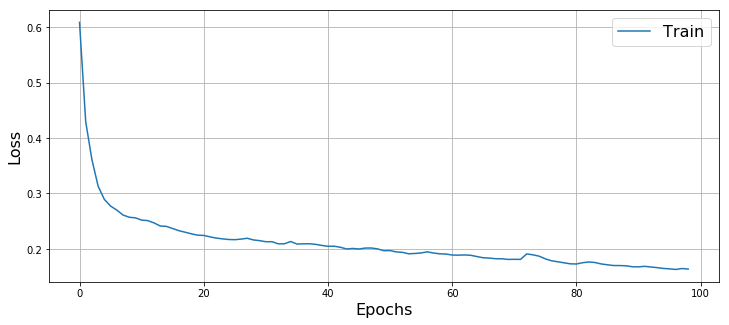

 50%|█████████████████████████████████████▌                                      | 99/200 [3:03:57<2:56:14, 104.70s/it]

Epoch 99... (Train/Test) MSE: 0.164/0.164


 50%|█████████████████████████████████████▌                                     | 100/200 [3:05:42<2:54:38, 104.78s/it]

Epoch 100... (Train/Test) MSE: 0.164/0.164


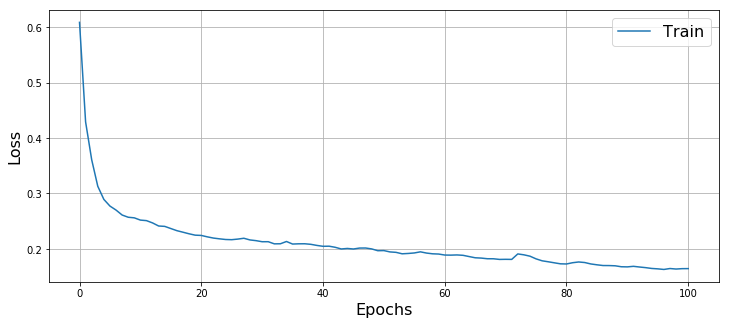

 50%|█████████████████████████████████████▉                                     | 101/200 [3:07:27<2:52:41, 104.66s/it]

Epoch 101... (Train/Test) MSE: 0.165/0.165


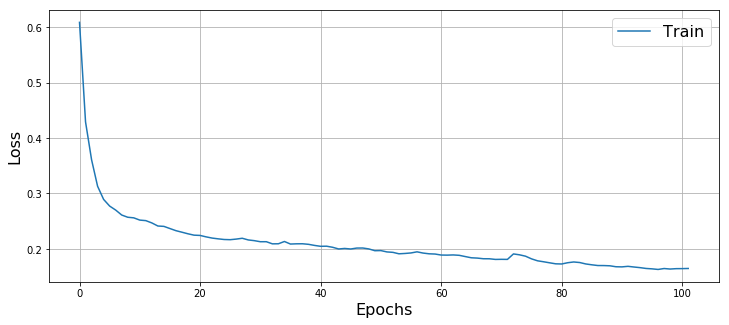

 51%|██████████████████████████████████████▎                                    | 102/200 [3:09:11<2:50:58, 104.68s/it]

Epoch 102... (Train/Test) MSE: 0.163/0.163


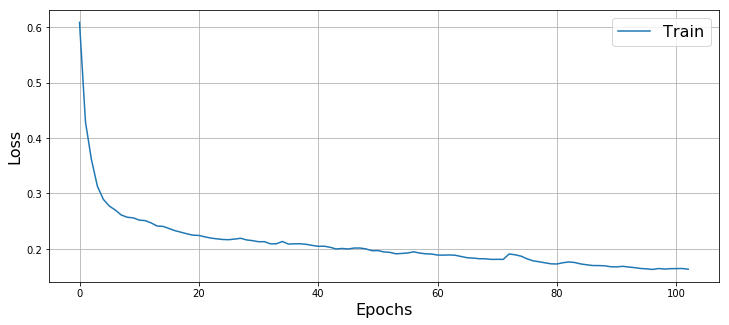

 52%|██████████████████████████████████████▋                                    | 103/200 [3:10:57<2:49:54, 105.09s/it]

Epoch 103... (Train/Test) MSE: 0.161/0.161


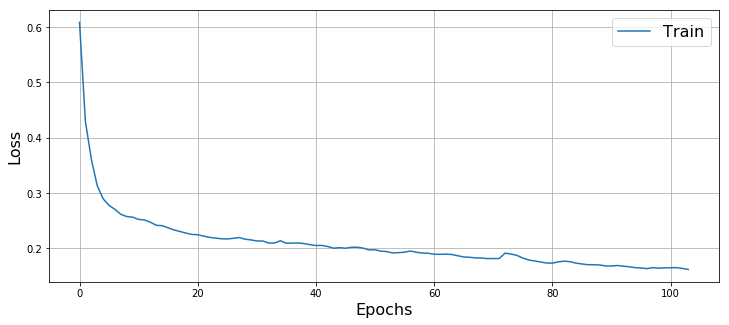

 52%|███████████████████████████████████████                                    | 104/200 [3:12:31<2:42:48, 101.76s/it]

Epoch 104... (Train/Test) MSE: 0.160/0.160


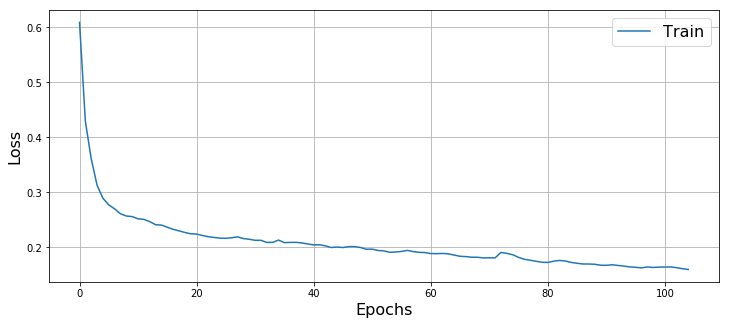

 52%|███████████████████████████████████████▉                                    | 105/200 [3:14:05<2:37:16, 99.33s/it]

Epoch 105... (Train/Test) MSE: 0.158/0.158


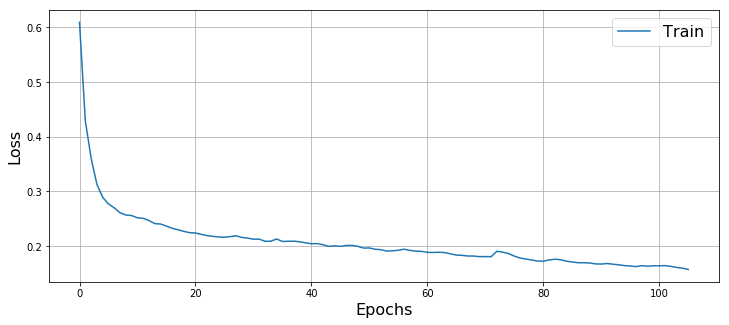

 53%|████████████████████████████████████████▎                                   | 106/200 [3:15:39<2:32:57, 97.64s/it]

Epoch 106... (Train/Test) MSE: 0.157/0.157


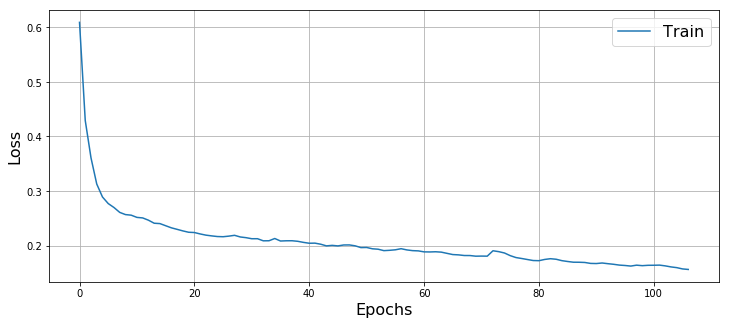

 54%|████████████████████████████████████████▋                                   | 107/200 [3:17:12<2:29:16, 96.31s/it]

Epoch 107... (Train/Test) MSE: 0.156/0.156


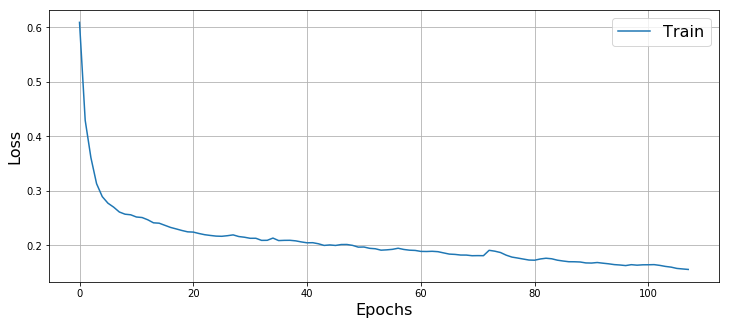

 54%|█████████████████████████████████████████                                   | 108/200 [3:18:57<2:31:53, 99.06s/it]

Epoch 108... (Train/Test) MSE: 0.155/0.155


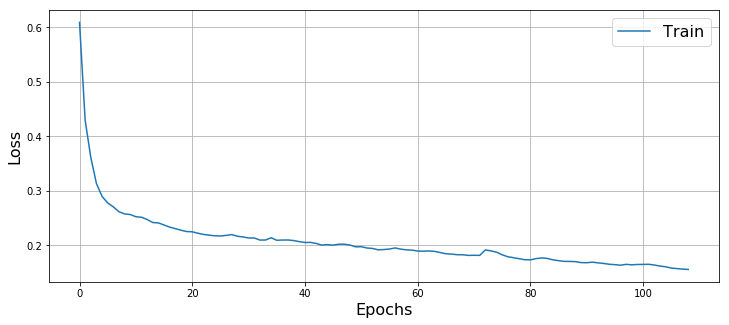

 55%|████████████████████████████████████████▉                                  | 109/200 [3:20:46<2:34:26, 101.83s/it]

Epoch 109... (Train/Test) MSE: 0.155/0.155


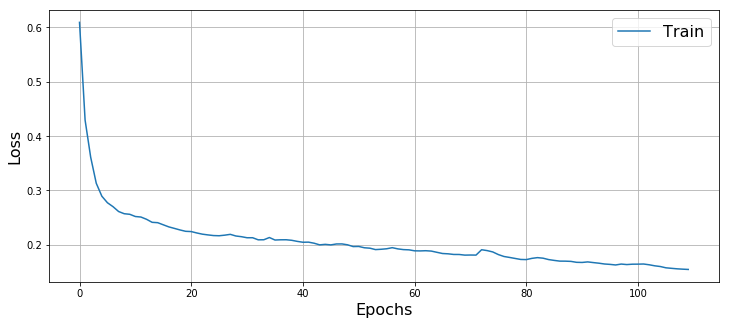

 55%|█████████████████████████████████████████▎                                 | 110/200 [3:22:34<2:35:41, 103.80s/it]

Epoch 110... (Train/Test) MSE: 0.157/0.157


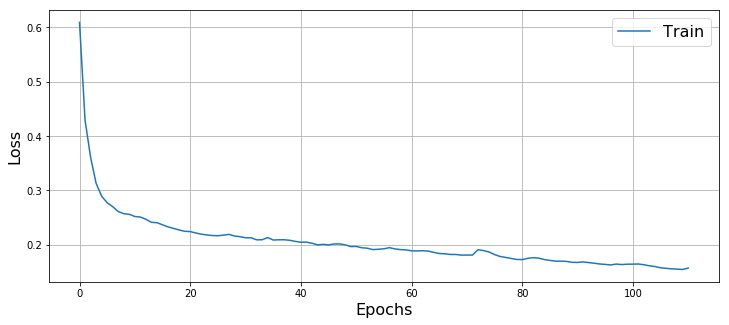

 56%|█████████████████████████████████████████▋                                 | 111/200 [3:24:22<2:35:47, 105.03s/it]

Epoch 111... (Train/Test) MSE: 0.155/0.155


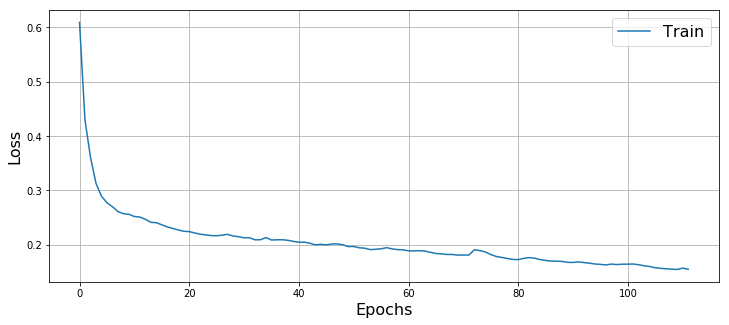

 56%|██████████████████████████████████████████                                 | 112/200 [3:26:11<2:35:37, 106.11s/it]

Epoch 112... (Train/Test) MSE: 0.155/0.155


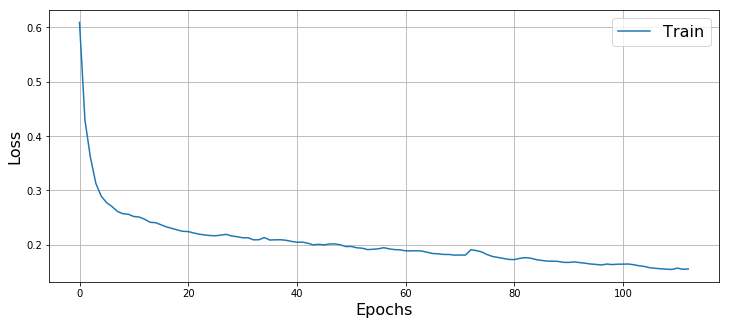

 56%|██████████████████████████████████████████▎                                | 113/200 [3:27:59<2:34:58, 106.88s/it]

Epoch 113... (Train/Test) MSE: 0.156/0.156


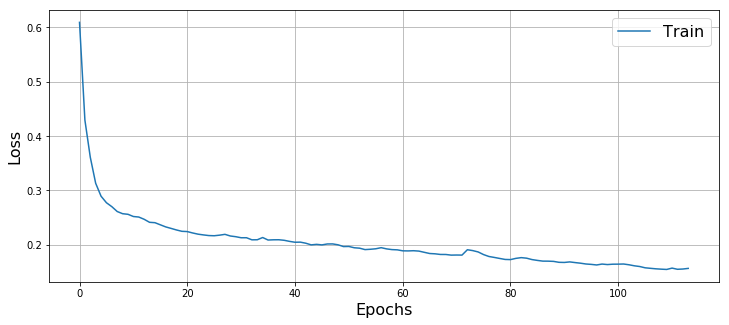

 57%|██████████████████████████████████████████▋                                | 114/200 [3:29:48<2:33:52, 107.35s/it]

Epoch 114... (Train/Test) MSE: 0.157/0.157


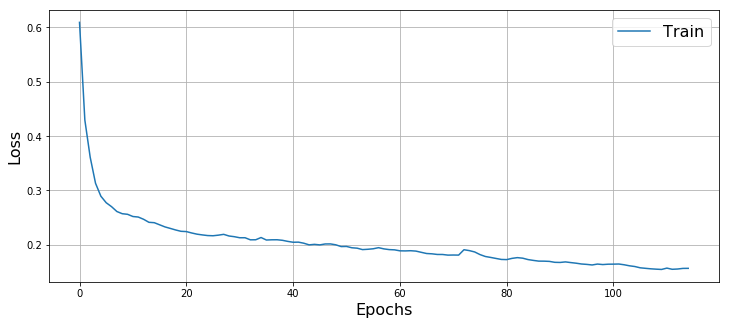

 57%|███████████████████████████████████████████▏                               | 115/200 [3:31:36<2:32:31, 107.66s/it]

Epoch 115... (Train/Test) MSE: 0.154/0.154


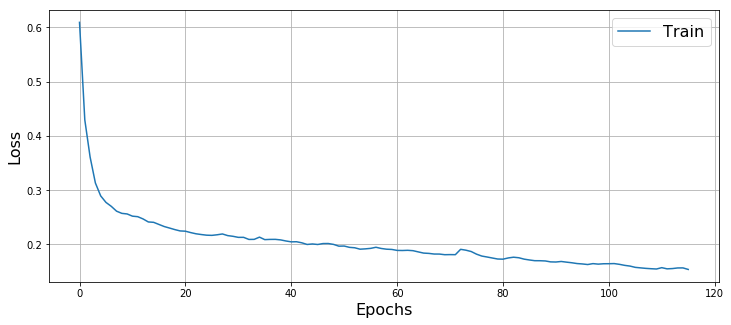

 58%|███████████████████████████████████████████▌                               | 116/200 [3:33:25<2:31:00, 107.87s/it]

Epoch 116... (Train/Test) MSE: 0.148/0.148


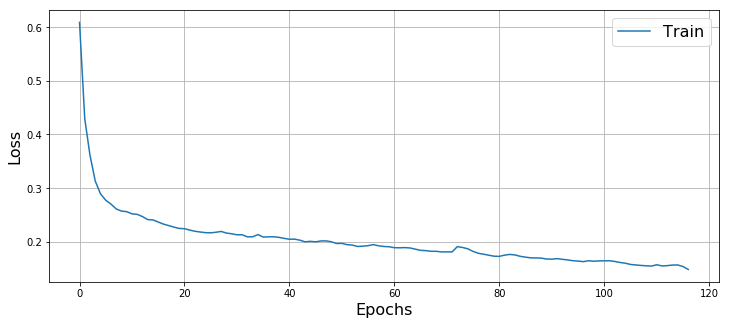

 58%|███████████████████████████████████████████▉                               | 117/200 [3:35:13<2:29:37, 108.17s/it]

Epoch 117... (Train/Test) MSE: 0.147/0.147


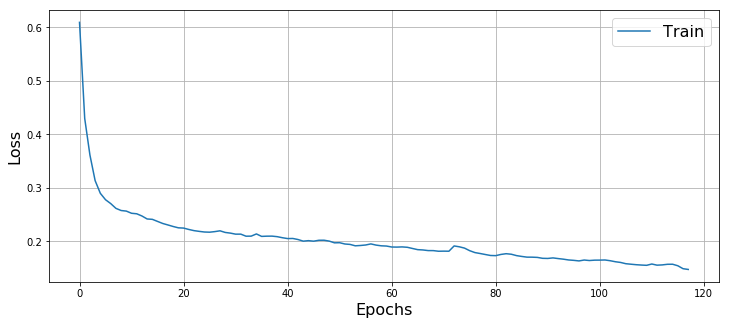

 59%|████████████████████████████████████████████▎                              | 118/200 [3:37:02<2:28:10, 108.42s/it]

Epoch 118... (Train/Test) MSE: 0.147/0.147


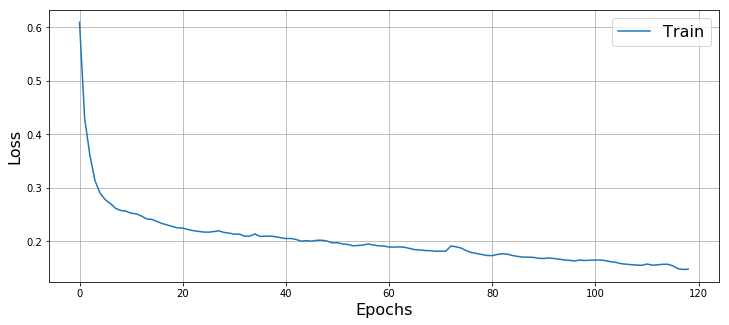

 60%|████████████████████████████████████████████▋                              | 119/200 [3:38:50<2:26:09, 108.27s/it]

Epoch 119... (Train/Test) MSE: 0.147/0.147


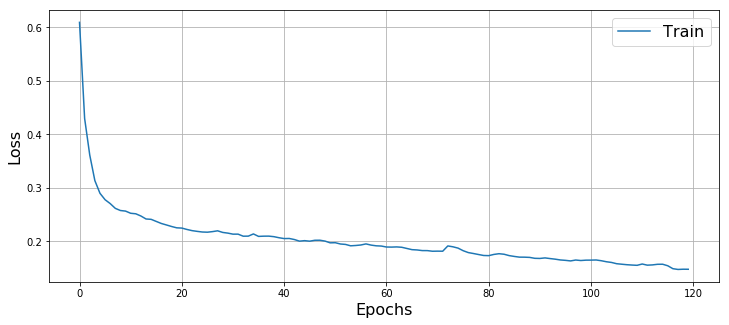

 60%|█████████████████████████████████████████████                              | 120/200 [3:40:39<2:24:21, 108.27s/it]

Epoch 120... (Train/Test) MSE: 0.147/0.147


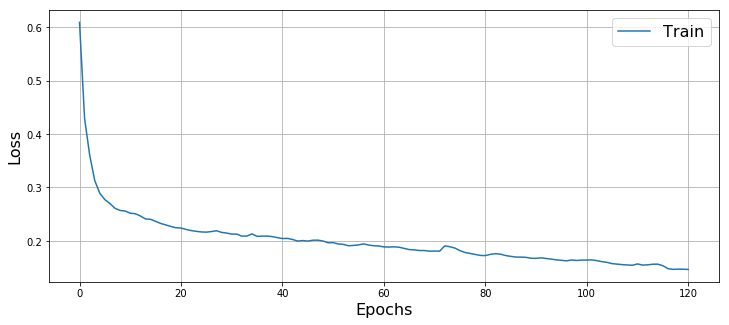

 60%|█████████████████████████████████████████████▍                             | 121/200 [3:42:27<2:22:41, 108.37s/it]

Epoch 121... (Train/Test) MSE: 0.145/0.145


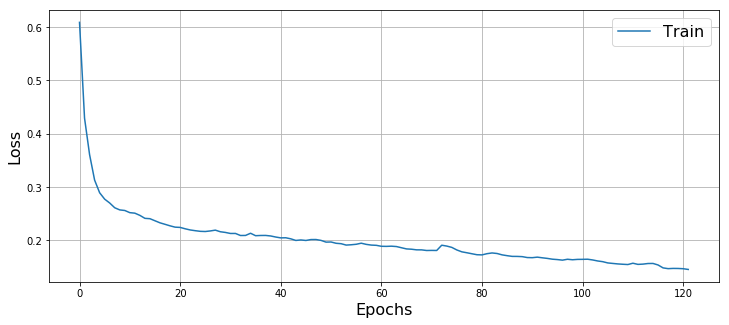

 61%|█████████████████████████████████████████████▊                             | 122/200 [3:44:15<2:20:44, 108.26s/it]

Epoch 122... (Train/Test) MSE: 0.142/0.142


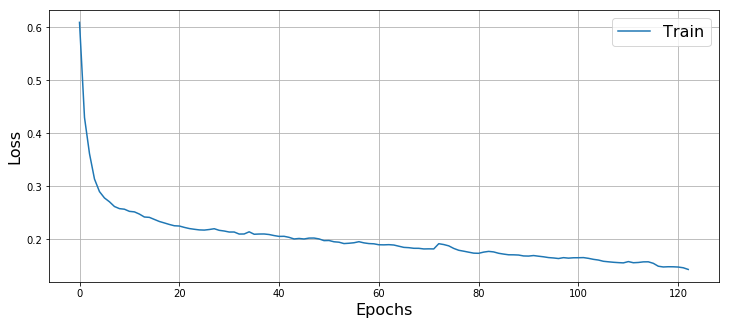

 62%|██████████████████████████████████████████████▏                            | 123/200 [3:46:03<2:18:50, 108.19s/it]

Epoch 123... (Train/Test) MSE: 0.141/0.141


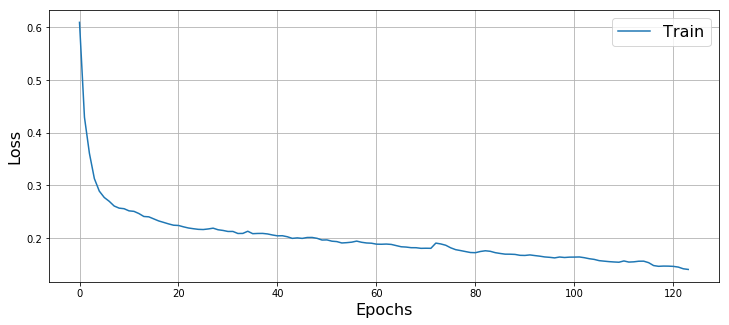

 62%|██████████████████████████████████████████████▌                            | 124/200 [3:47:52<2:17:05, 108.22s/it]

Epoch 124... (Train/Test) MSE: 0.141/0.141


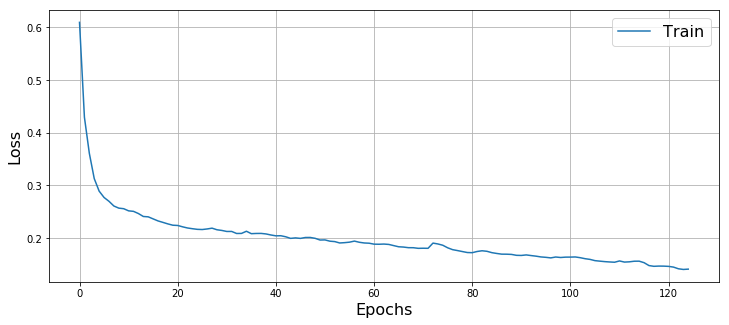

 62%|██████████████████████████████████████████████▉                            | 125/200 [3:49:39<2:15:08, 108.12s/it]

Epoch 125... (Train/Test) MSE: 0.139/0.139


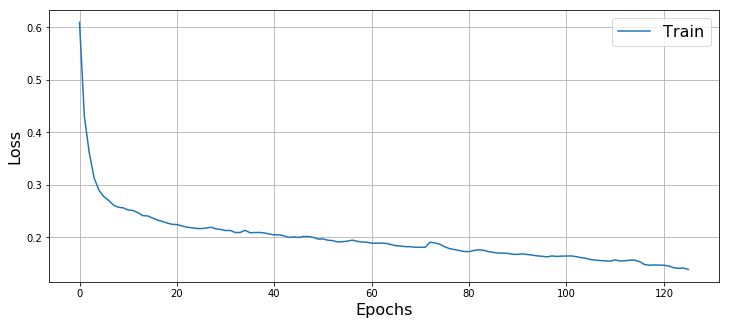

 63%|███████████████████████████████████████████████▎                           | 126/200 [3:51:28<2:13:21, 108.13s/it]

Epoch 126... (Train/Test) MSE: 0.139/0.139


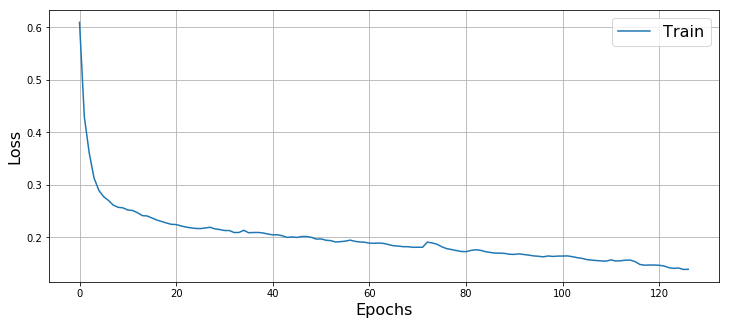

 64%|███████████████████████████████████████████████▋                           | 127/200 [3:53:16<2:11:44, 108.28s/it]

Epoch 127... (Train/Test) MSE: 0.137/0.137


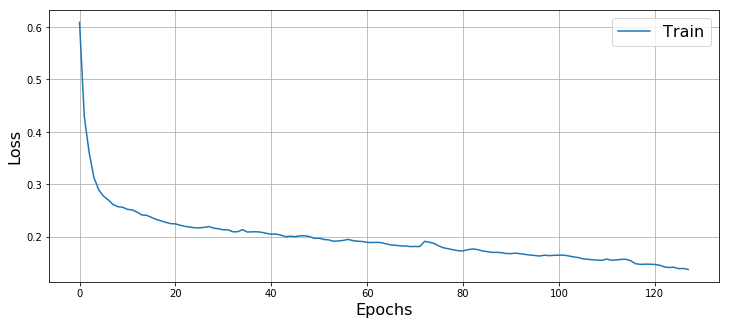

 64%|████████████████████████████████████████████████                           | 128/200 [3:55:05<2:09:58, 108.31s/it]

Epoch 128... (Train/Test) MSE: 0.138/0.138


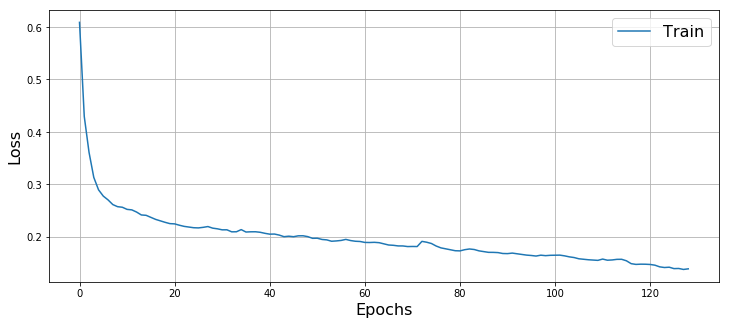

 64%|████████████████████████████████████████████████▍                          | 129/200 [3:56:53<2:08:14, 108.37s/it]

Epoch 129... (Train/Test) MSE: 0.138/0.138


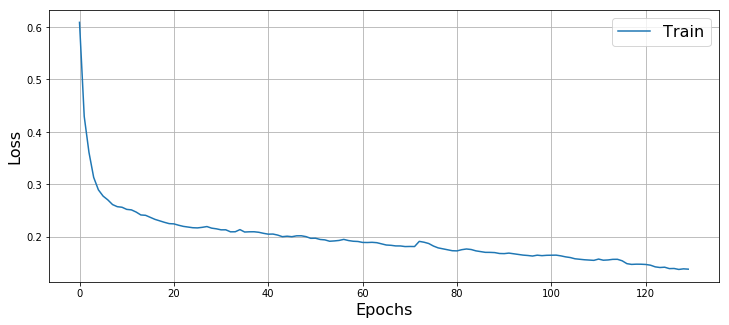

 65%|████████████████████████████████████████████████▊                          | 130/200 [3:58:41<2:06:26, 108.37s/it]

Epoch 130... (Train/Test) MSE: 0.136/0.136


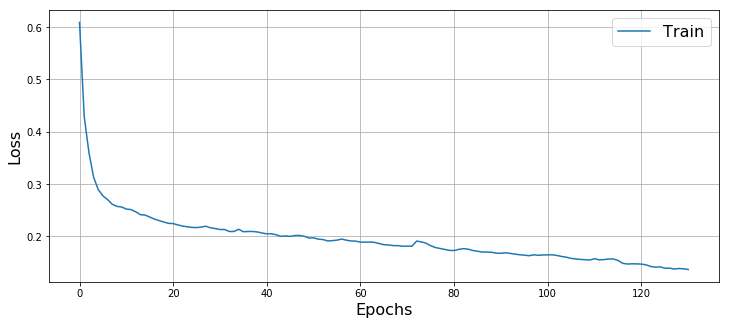

 66%|█████████████████████████████████████████████████▏                         | 131/200 [4:00:30<2:04:37, 108.36s/it]

Epoch 131... (Train/Test) MSE: 0.137/0.137


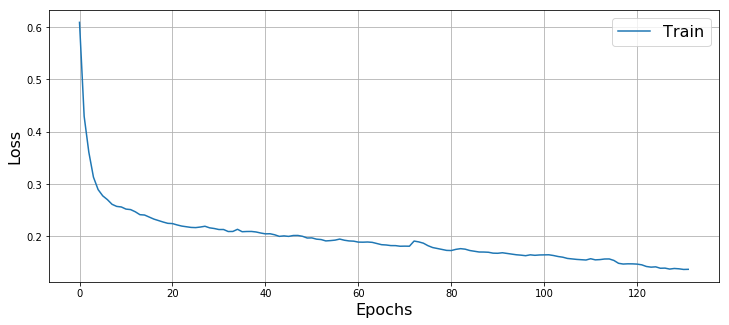

 66%|█████████████████████████████████████████████████▌                         | 132/200 [4:02:18<2:02:52, 108.42s/it]

Epoch 132... (Train/Test) MSE: 0.139/0.139


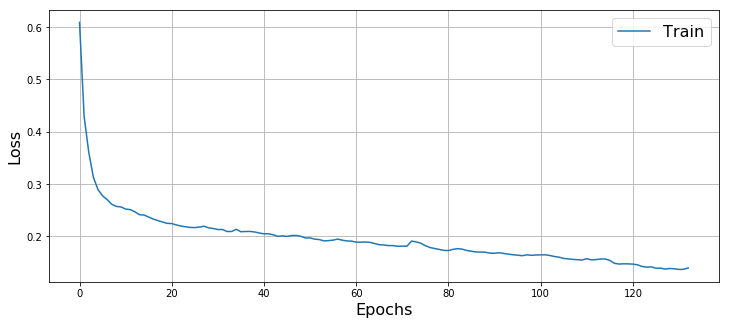

 66%|█████████████████████████████████████████████████▉                         | 133/200 [4:04:07<2:01:06, 108.45s/it]

Epoch 133... (Train/Test) MSE: 0.140/0.140


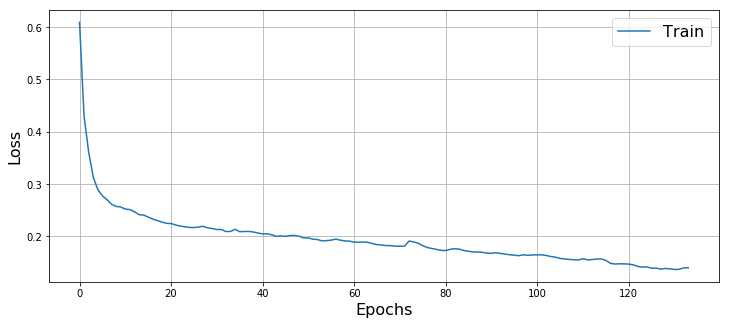

 67%|██████████████████████████████████████████████████▎                        | 134/200 [4:05:55<1:59:17, 108.45s/it]

Epoch 134... (Train/Test) MSE: 0.136/0.136


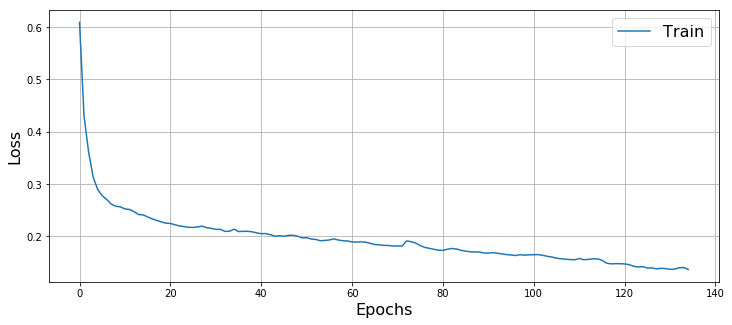

 68%|██████████████████████████████████████████████████▋                        | 135/200 [4:07:43<1:57:18, 108.28s/it]

Epoch 135... (Train/Test) MSE: 0.133/0.133


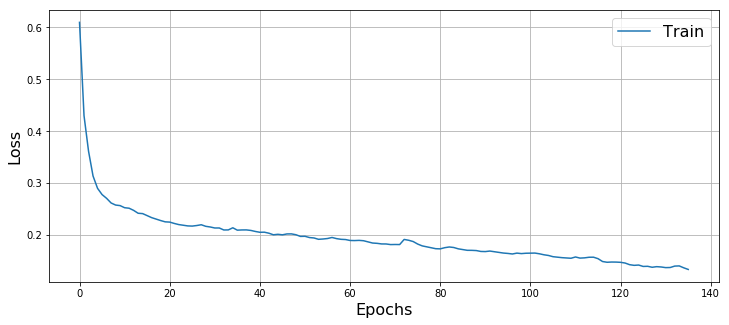

 68%|███████████████████████████████████████████████████                        | 136/200 [4:09:31<1:55:26, 108.22s/it]

Epoch 136... (Train/Test) MSE: 0.129/0.129


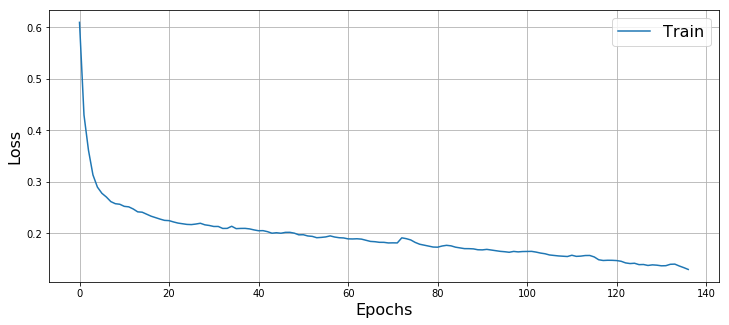

 68%|███████████████████████████████████████████████████▍                       | 137/200 [4:11:19<1:53:35, 108.18s/it]

Epoch 137... (Train/Test) MSE: 0.127/0.127


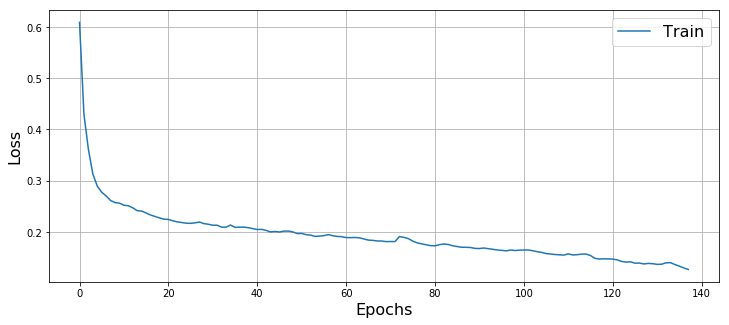

 69%|███████████████████████████████████████████████████▋                       | 138/200 [4:13:08<1:51:53, 108.28s/it]

Epoch 138... (Train/Test) MSE: 0.125/0.125


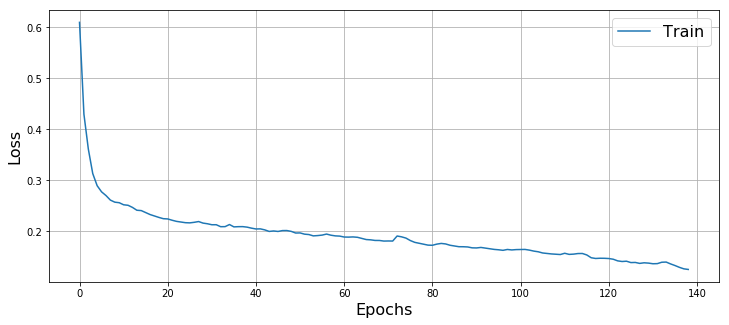

 70%|████████████████████████████████████████████████████                       | 139/200 [4:14:56<1:49:54, 108.11s/it]

Epoch 139... (Train/Test) MSE: 0.125/0.125


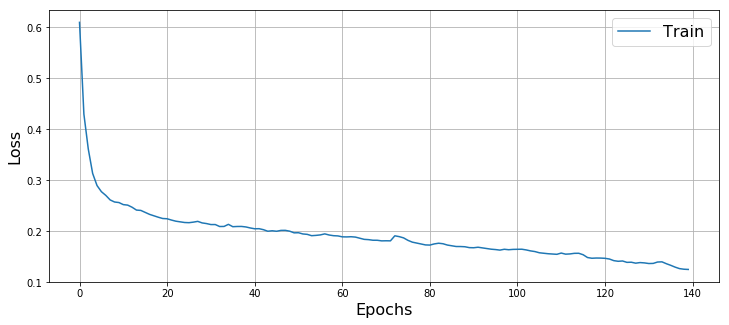

 70%|████████████████████████████████████████████████████▌                      | 140/200 [4:16:44<1:48:08, 108.15s/it]

Epoch 140... (Train/Test) MSE: 0.125/0.125


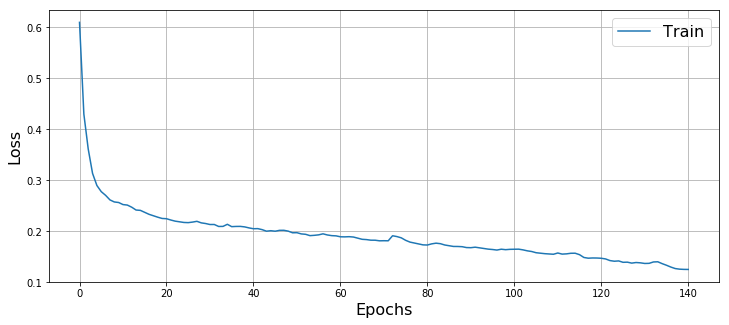

 70%|████████████████████████████████████████████████████▉                      | 141/200 [4:18:51<1:51:56, 113.84s/it]

Epoch 141... (Train/Test) MSE: 0.122/0.122


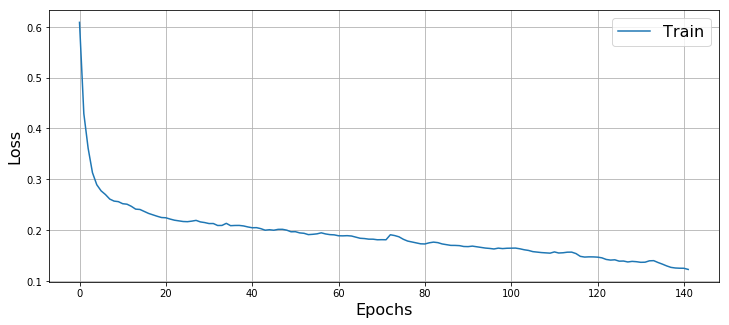

 71%|█████████████████████████████████████████████████████▎                     | 142/200 [4:21:58<2:11:11, 135.71s/it]

Epoch 142... (Train/Test) MSE: 0.124/0.124


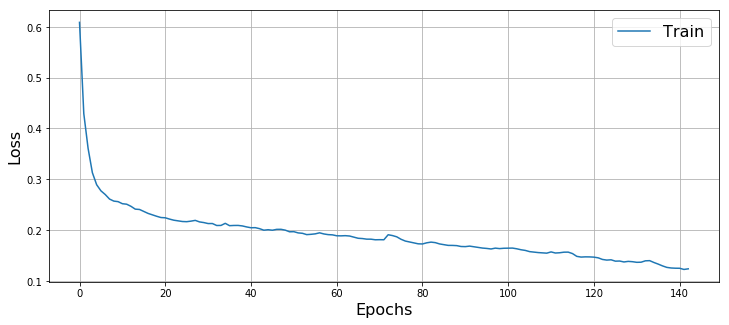

 72%|█████████████████████████████████████████████████████▋                     | 143/200 [4:25:05<2:23:32, 151.10s/it]

Epoch 143... (Train/Test) MSE: 0.123/0.123


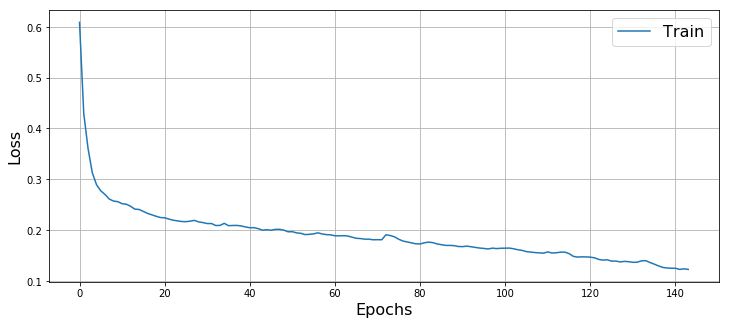

 72%|██████████████████████████████████████████████████████                     | 144/200 [4:28:12<2:31:04, 161.87s/it]

Epoch 144... (Train/Test) MSE: 0.121/0.121


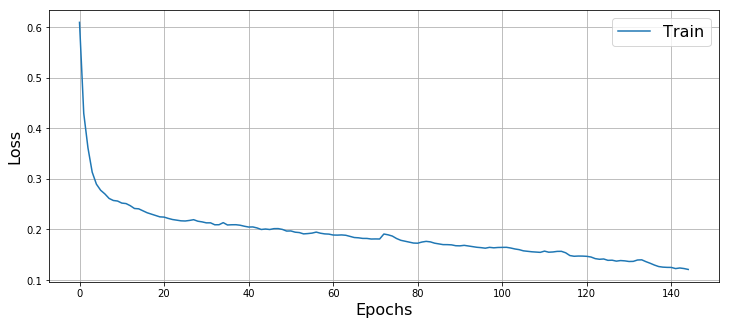

 72%|██████████████████████████████████████████████████████▍                    | 145/200 [4:31:18<2:35:06, 169.22s/it]

Epoch 145... (Train/Test) MSE: 0.121/0.121


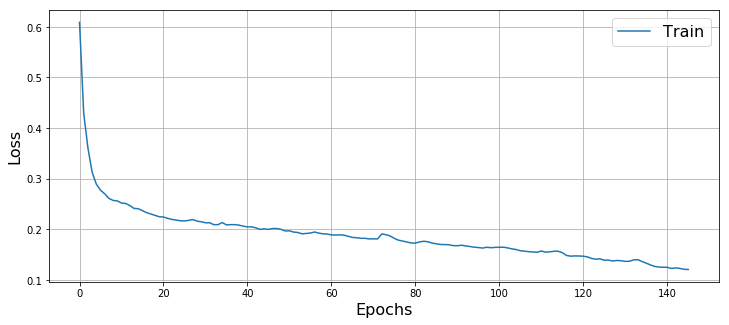

 73%|██████████████████████████████████████████████████████▊                    | 146/200 [4:34:24<2:36:54, 174.33s/it]

Epoch 146... (Train/Test) MSE: 0.119/0.119


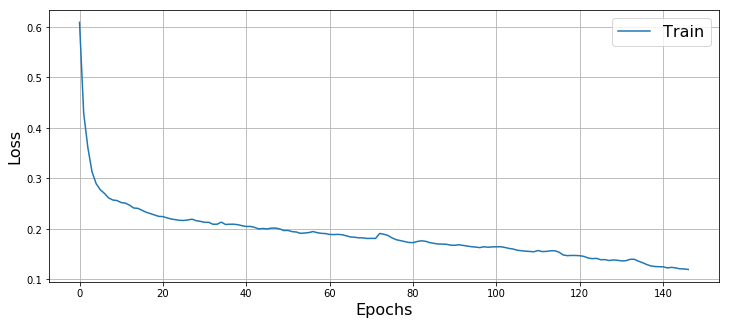

 74%|███████████████████████████████████████████████████████▏                   | 147/200 [4:37:32<2:37:23, 178.18s/it]

Epoch 147... (Train/Test) MSE: 0.120/0.120


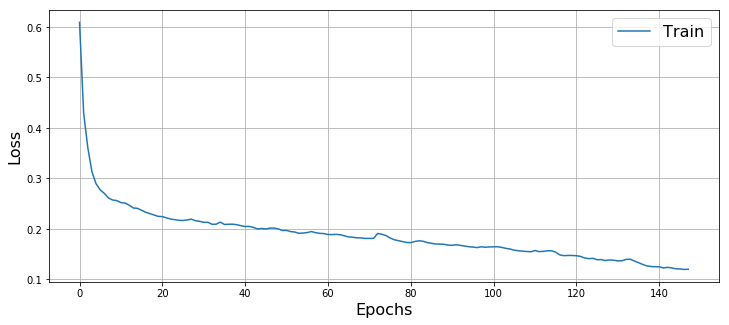

 74%|███████████████████████████████████████████████████████▌                   | 148/200 [4:41:35<2:51:23, 197.76s/it]

Epoch 148... (Train/Test) MSE: 0.124/0.124


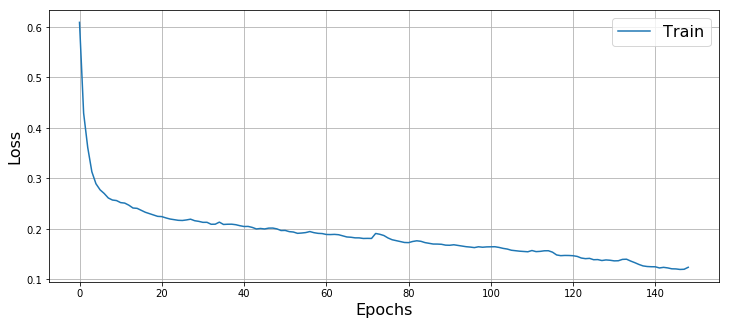

 74%|███████████████████████████████████████████████████████▉                   | 149/200 [4:43:19<2:24:11, 169.64s/it]

Epoch 149... (Train/Test) MSE: 0.127/0.127


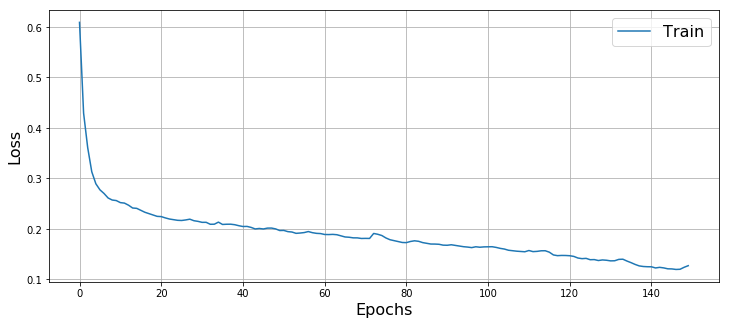

 75%|████████████████████████████████████████████████████████▎                  | 150/200 [4:45:02<2:04:46, 149.72s/it]

Epoch 150... (Train/Test) MSE: 0.126/0.126


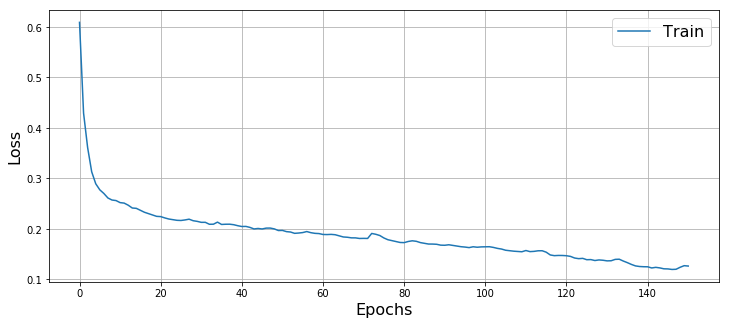

 76%|████████████████████████████████████████████████████████▋                  | 151/200 [4:46:46<1:51:01, 135.95s/it]

Epoch 151... (Train/Test) MSE: 0.125/0.125


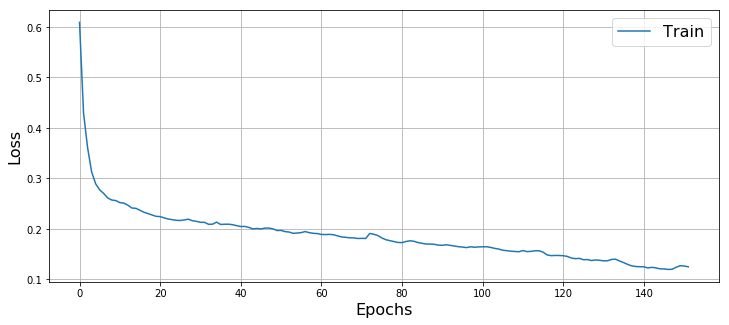

 76%|█████████████████████████████████████████████████████████                  | 152/200 [4:48:30<1:41:00, 126.26s/it]

Epoch 152... (Train/Test) MSE: 0.123/0.123


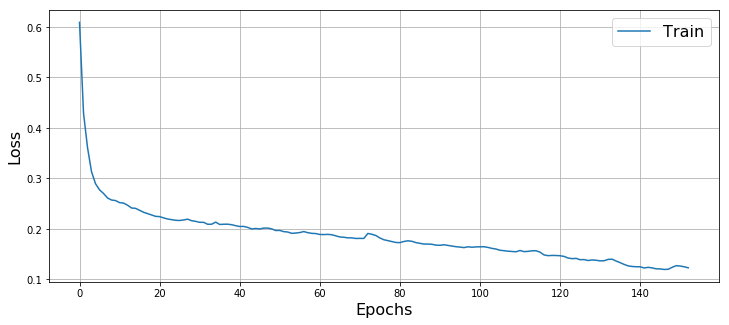

 76%|█████████████████████████████████████████████████████████▍                 | 153/200 [4:50:14<1:33:44, 119.66s/it]

Epoch 153... (Train/Test) MSE: 0.122/0.122


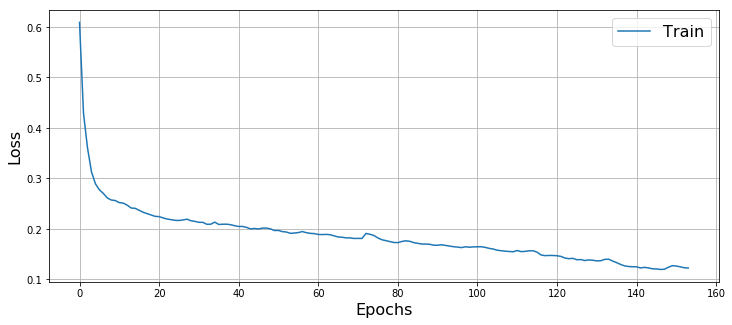

 77%|█████████████████████████████████████████████████████████▊                 | 154/200 [4:51:58<1:28:02, 114.84s/it]

Epoch 154... (Train/Test) MSE: 0.122/0.122


 78%|██████████████████████████████████████████████████████████▏                | 155/200 [4:53:41<1:23:38, 111.52s/it]

Epoch 155... (Train/Test) MSE: 0.120/0.120


 78%|██████████████████████████████████████████████████████████▌                | 156/200 [4:55:25<1:20:03, 109.16s/it]

Epoch 156... (Train/Test) MSE: 0.115/0.115


 78%|██████████████████████████████████████████████████████████▉                | 157/200 [4:57:09<1:17:01, 107.48s/it]

Epoch 157... (Train/Test) MSE: 0.113/0.113


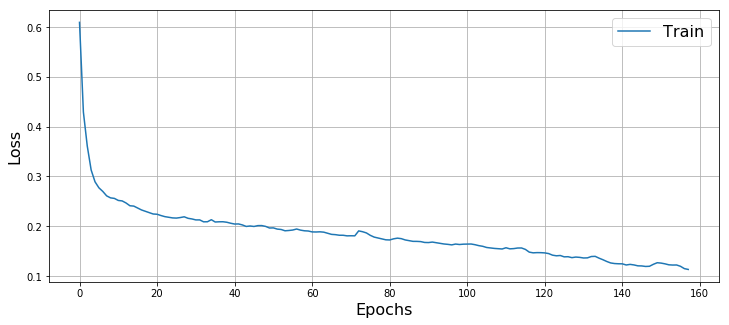

 79%|███████████████████████████████████████████████████████████▎               | 158/200 [4:58:52<1:14:26, 106.35s/it]

Epoch 158... (Train/Test) MSE: 0.112/0.112


 80%|███████████████████████████████████████████████████████████▋               | 159/200 [5:00:36<1:12:07, 105.56s/it]

Epoch 159... (Train/Test) MSE: 0.113/0.113


 80%|████████████████████████████████████████████████████████████               | 160/200 [5:02:20<1:09:59, 105.00s/it]

Epoch 160... (Train/Test) MSE: 0.110/0.110


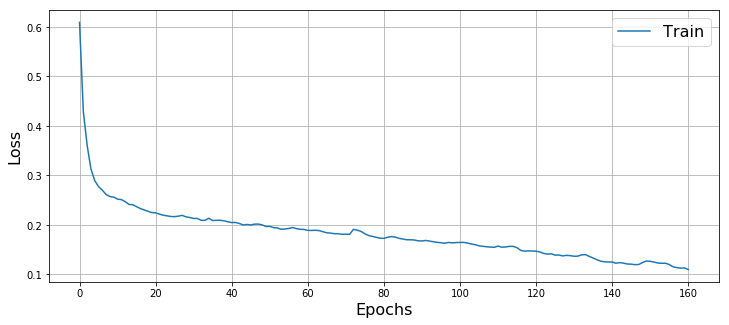

 80%|████████████████████████████████████████████████████████████▍              | 161/200 [5:04:03<1:08:00, 104.62s/it]

Epoch 161... (Train/Test) MSE: 0.108/0.108


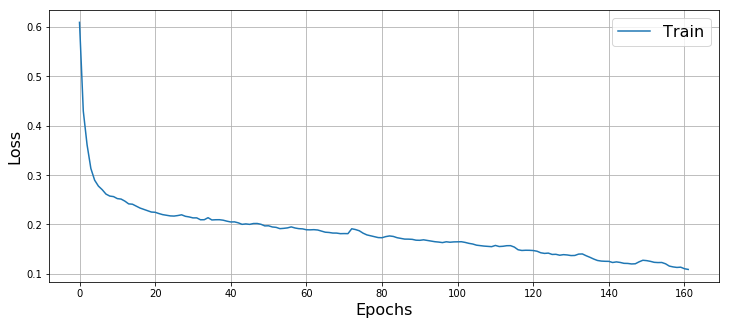

 81%|████████████████████████████████████████████████████████████▊              | 162/200 [5:05:47<1:06:08, 104.45s/it]

Epoch 162... (Train/Test) MSE: 0.107/0.107


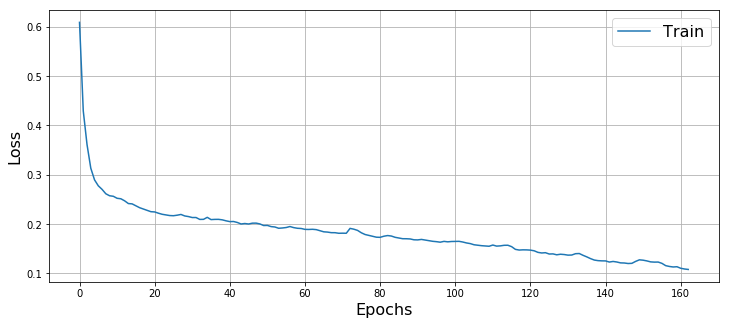

 82%|█████████████████████████████████████████████████████████████              | 163/200 [5:07:31<1:04:19, 104.32s/it]

Epoch 163... (Train/Test) MSE: 0.107/0.107


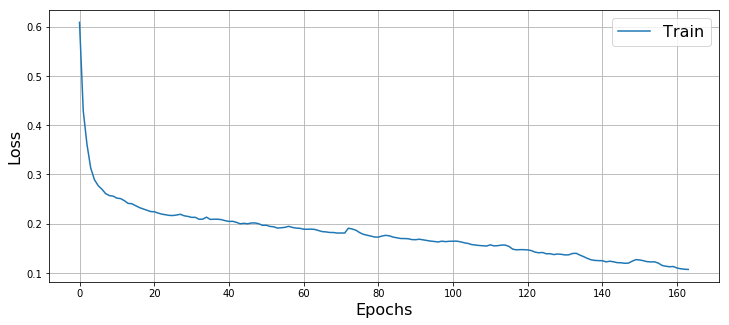

 82%|█████████████████████████████████████████████████████████████▍             | 164/200 [5:09:15<1:02:28, 104.12s/it]

Epoch 164... (Train/Test) MSE: 0.107/0.107


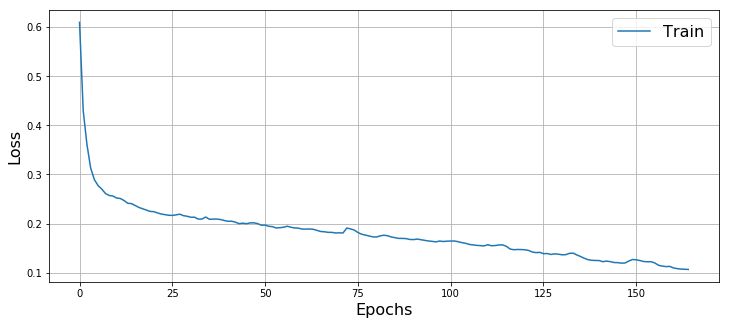

 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [5:10:59<1:00:41, 104.04s/it]

Epoch 165... (Train/Test) MSE: 0.106/0.106


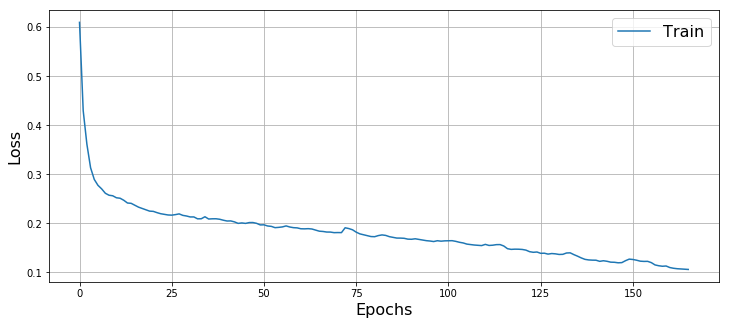

 83%|███████████████████████████████████████████████████████████████▉             | 166/200 [5:12:43<58:54, 103.97s/it]

Epoch 166... (Train/Test) MSE: 0.104/0.104


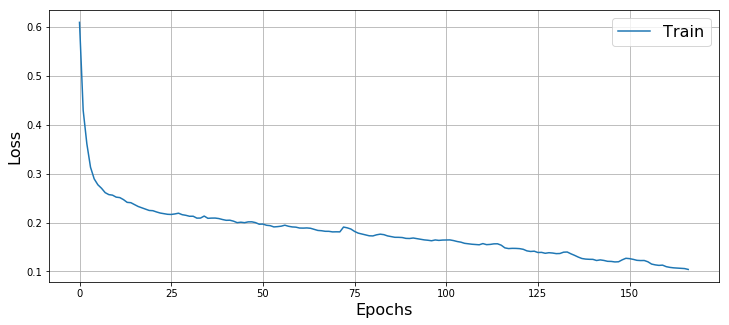

 84%|████████████████████████████████████████████████████████████████▎            | 167/200 [5:14:26<57:08, 103.89s/it]

Epoch 167... (Train/Test) MSE: 0.103/0.103


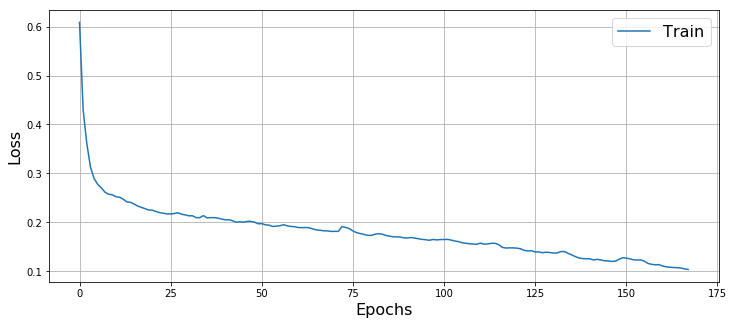

 84%|████████████████████████████████████████████████████████████████▋            | 168/200 [5:16:10<55:24, 103.88s/it]

Epoch 168... (Train/Test) MSE: 0.101/0.101


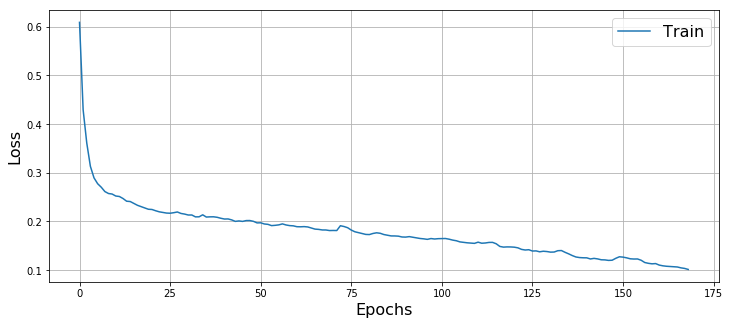

 84%|█████████████████████████████████████████████████████████████████            | 169/200 [5:17:54<53:42, 103.94s/it]

Epoch 169... (Train/Test) MSE: 0.101/0.101


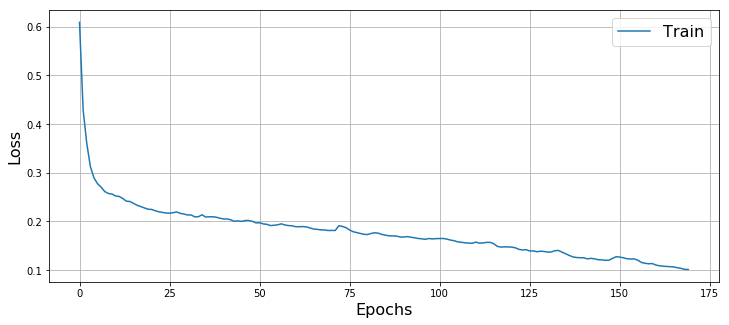

 85%|█████████████████████████████████████████████████████████████████▍           | 170/200 [5:19:38<51:56, 103.89s/it]

Epoch 170... (Train/Test) MSE: 0.099/0.099


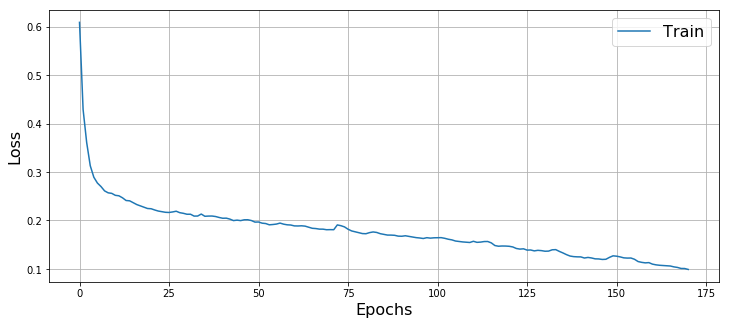

 86%|█████████████████████████████████████████████████████████████████▊           | 171/200 [5:21:22<50:11, 103.86s/it]

Epoch 171... (Train/Test) MSE: 0.098/0.098


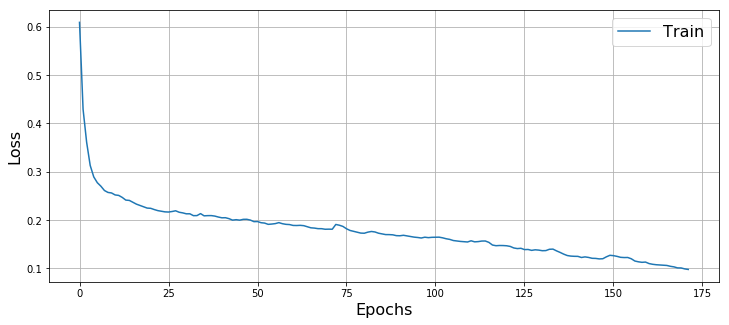

 86%|██████████████████████████████████████████████████████████████████▏          | 172/200 [5:23:05<48:23, 103.69s/it]

Epoch 172... (Train/Test) MSE: 0.099/0.099


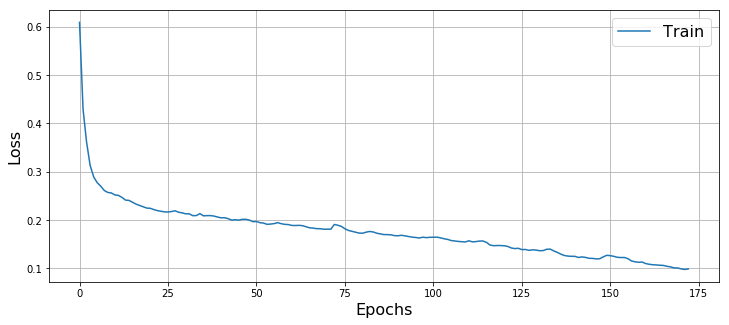

 86%|██████████████████████████████████████████████████████████████████▌          | 173/200 [5:24:49<46:36, 103.58s/it]

Epoch 173... (Train/Test) MSE: 0.098/0.098


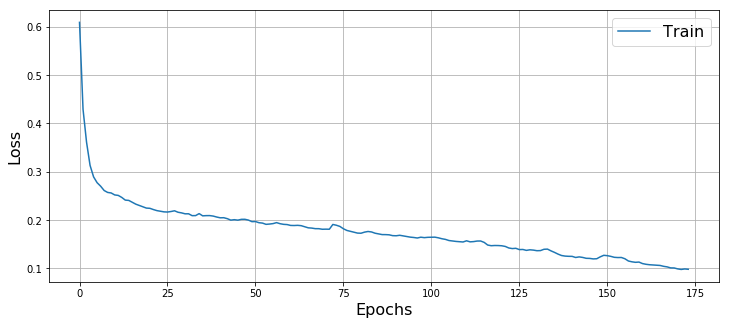

 87%|██████████████████████████████████████████████████████████████████▉          | 174/200 [5:26:32<44:49, 103.43s/it]

Epoch 174... (Train/Test) MSE: 0.096/0.096


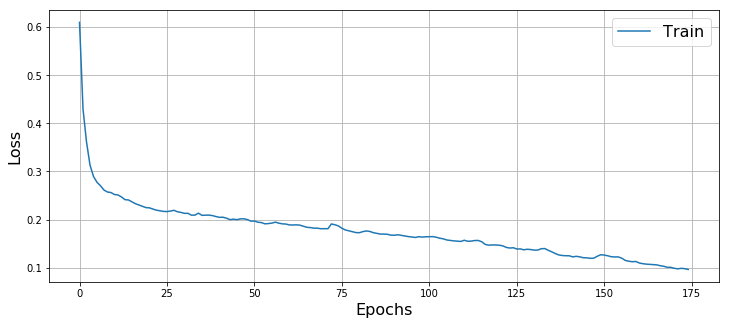

 88%|███████████████████████████████████████████████████████████████████▍         | 175/200 [5:28:16<43:09, 103.56s/it]

Epoch 175... (Train/Test) MSE: 0.097/0.097


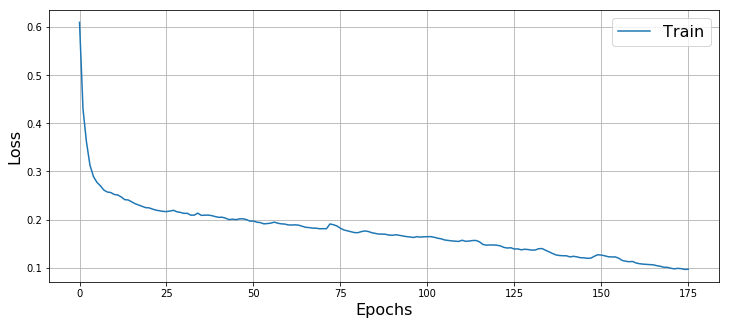

 88%|███████████████████████████████████████████████████████████████████▊         | 176/200 [5:30:00<41:30, 103.75s/it]

Epoch 176... (Train/Test) MSE: 0.097/0.097


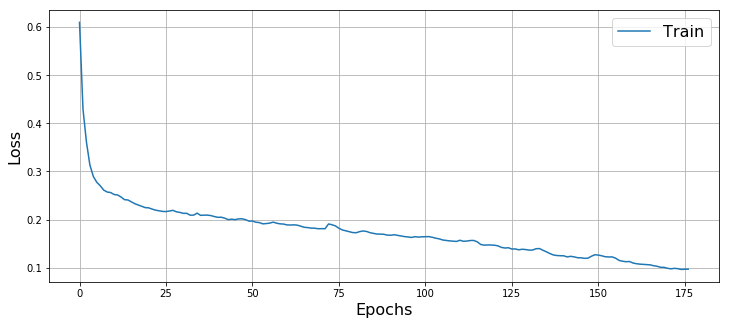

 88%|████████████████████████████████████████████████████████████████████▏        | 177/200 [5:31:44<39:47, 103.79s/it]

Epoch 177... (Train/Test) MSE: 0.096/0.096


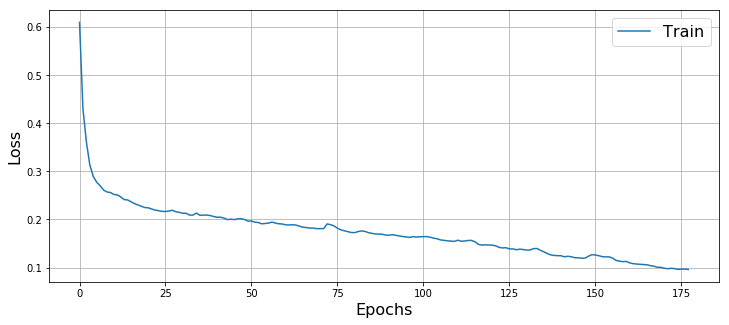

 89%|████████████████████████████████████████████████████████████████████▌        | 178/200 [5:33:27<38:02, 103.76s/it]

Epoch 178... (Train/Test) MSE: 0.096/0.096


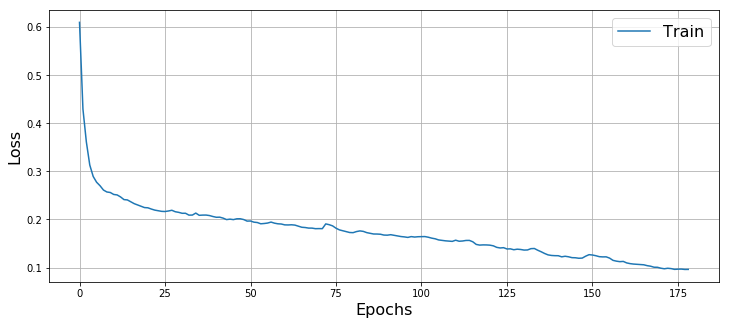

 90%|████████████████████████████████████████████████████████████████████▉        | 179/200 [5:35:11<36:19, 103.80s/it]

Epoch 179... (Train/Test) MSE: 0.096/0.096


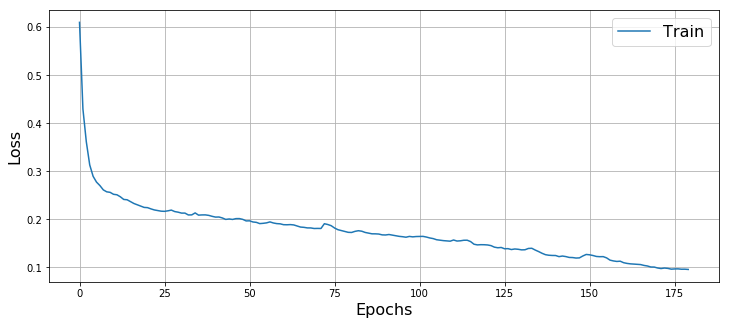

 90%|█████████████████████████████████████████████████████████████████████▎       | 180/200 [5:36:55<34:36, 103.82s/it]

Epoch 180... (Train/Test) MSE: 0.096/0.096


 90%|█████████████████████████████████████████████████████████████████████▋       | 181/200 [5:38:39<32:52, 103.83s/it]

Epoch 181... (Train/Test) MSE: 0.097/0.097


 91%|██████████████████████████████████████████████████████████████████████       | 182/200 [5:40:23<31:08, 103.83s/it]

Epoch 182... (Train/Test) MSE: 0.098/0.098


 92%|██████████████████████████████████████████████████████████████████████▍      | 183/200 [5:42:06<29:24, 103.79s/it]

Epoch 183... (Train/Test) MSE: 0.097/0.097


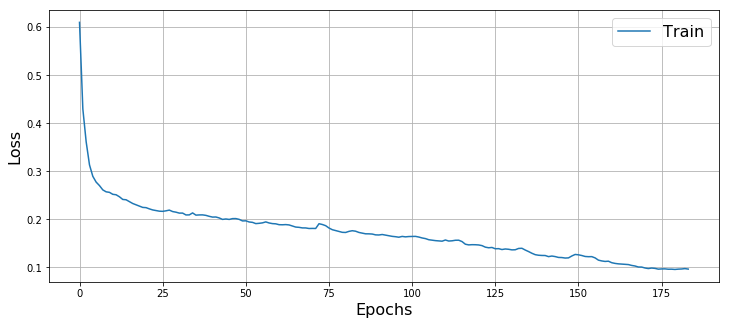

 92%|██████████████████████████████████████████████████████████████████████▊      | 184/200 [5:43:50<27:40, 103.77s/it]

Epoch 184... (Train/Test) MSE: 0.095/0.095


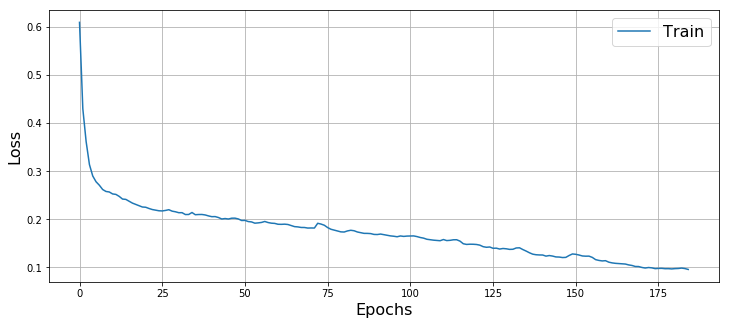

 92%|███████████████████████████████████████████████████████████████████████▏     | 185/200 [5:45:34<25:56, 103.78s/it]

Epoch 185... (Train/Test) MSE: 0.094/0.094


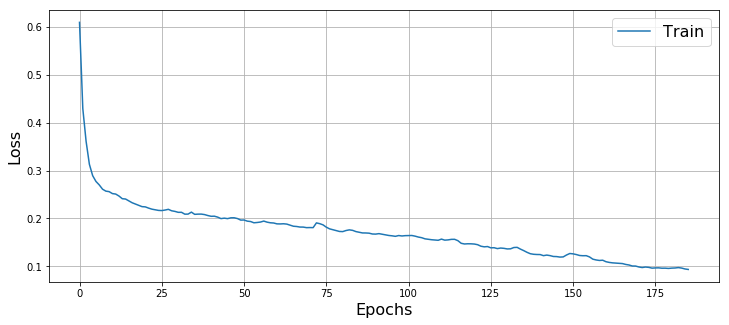

 93%|███████████████████████████████████████████████████████████████████████▌     | 186/200 [5:47:18<24:12, 103.77s/it]

Epoch 186... (Train/Test) MSE: 0.093/0.093


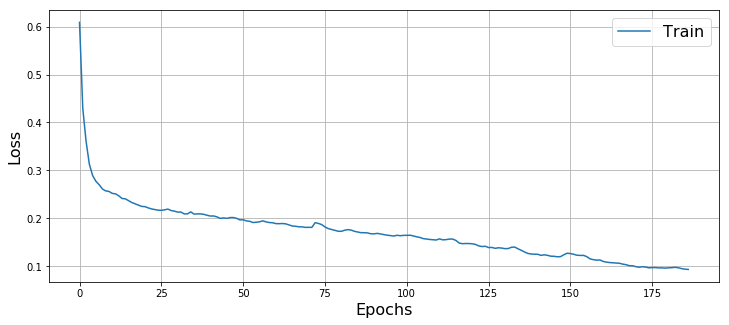

 94%|███████████████████████████████████████████████████████████████████████▉     | 187/200 [5:49:02<22:29, 103.78s/it]

Epoch 187... (Train/Test) MSE: 0.093/0.093


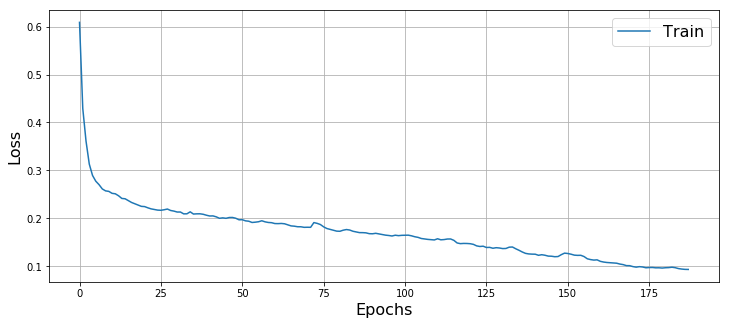

 94%|████████████████████████████████████████████████████████████████████████▍    | 188/200 [5:50:45<20:45, 103.75s/it]

Epoch 188... (Train/Test) MSE: 0.092/0.092


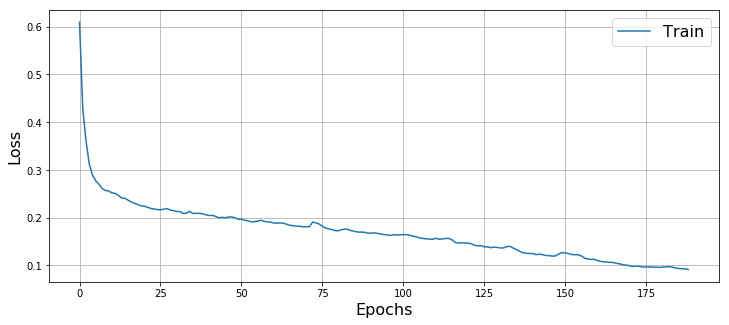

 94%|████████████████████████████████████████████████████████████████████████▊    | 189/200 [5:52:29<19:01, 103.77s/it]

Epoch 189... (Train/Test) MSE: 0.091/0.091


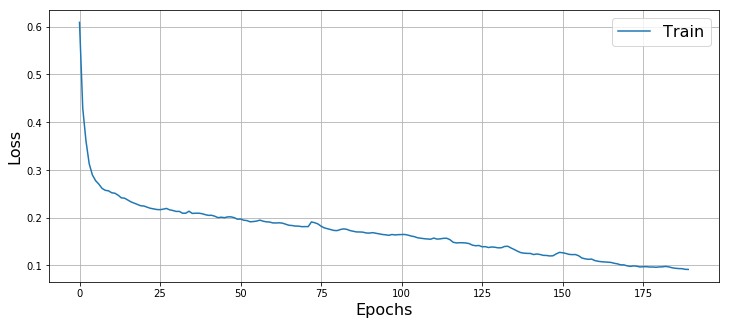

 95%|█████████████████████████████████████████████████████████████████████████▏   | 190/200 [5:54:13<17:16, 103.68s/it]

Epoch 190... (Train/Test) MSE: 0.090/0.090


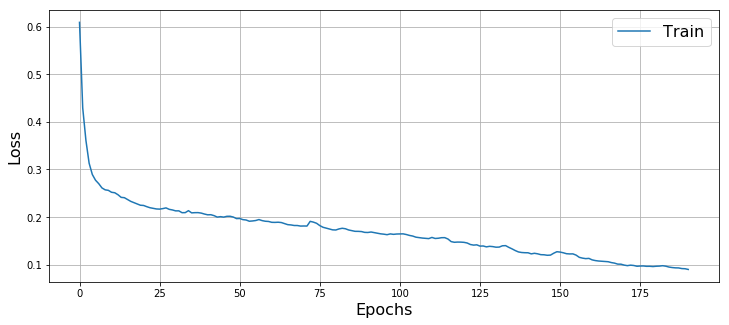

 96%|█████████████████████████████████████████████████████████████████████████▌   | 191/200 [5:55:56<15:32, 103.66s/it]

Epoch 191... (Train/Test) MSE: 0.090/0.090


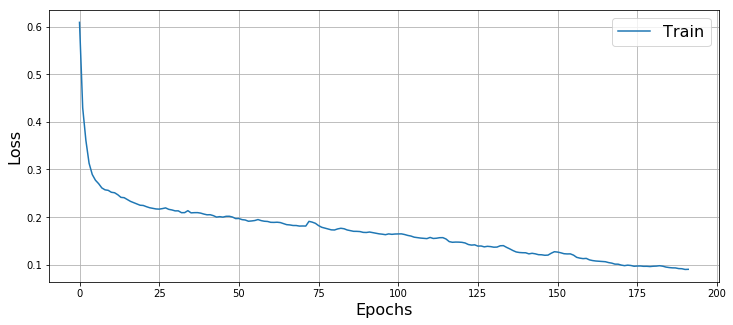

 96%|█████████████████████████████████████████████████████████████████████████▉   | 192/200 [5:57:40<13:50, 103.78s/it]

Epoch 192... (Train/Test) MSE: 0.091/0.091


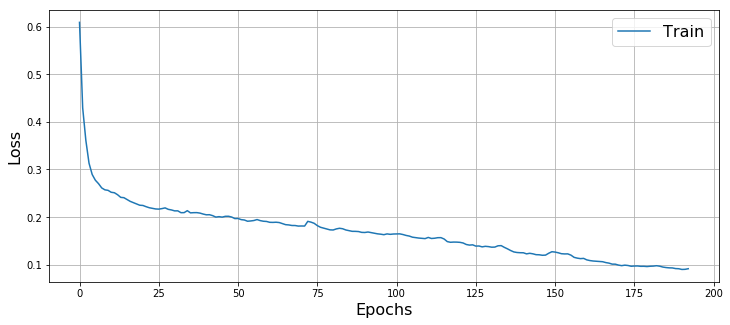

 96%|██████████████████████████████████████████████████████████████████████████▎  | 193/200 [5:59:24<12:05, 103.68s/it]

Epoch 193... (Train/Test) MSE: 0.090/0.090


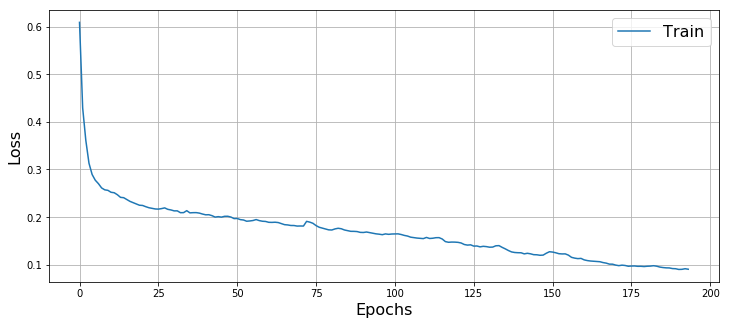

 97%|██████████████████████████████████████████████████████████████████████████▋  | 194/200 [6:01:07<10:22, 103.71s/it]

Epoch 194... (Train/Test) MSE: 0.092/0.092


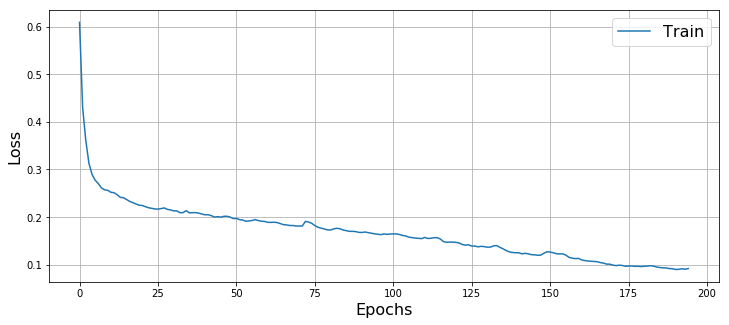

 98%|███████████████████████████████████████████████████████████████████████████  | 195/200 [6:02:51<08:38, 103.76s/it]

Epoch 195... (Train/Test) MSE: 0.093/0.093


 98%|███████████████████████████████████████████████████████████████████████████▍ | 196/200 [6:04:35<06:54, 103.71s/it]

Epoch 196... (Train/Test) MSE: 0.095/0.095


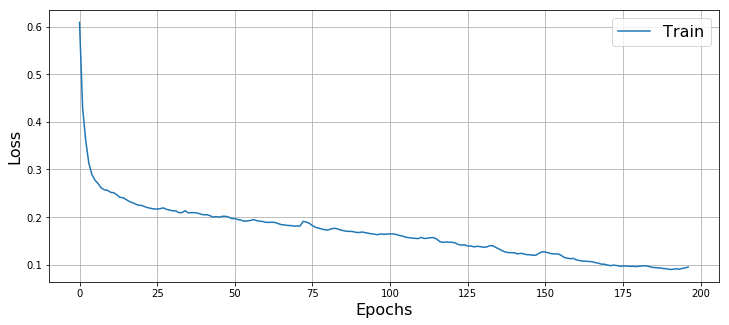

 98%|███████████████████████████████████████████████████████████████████████████▊ | 197/200 [6:06:19<05:11, 103.90s/it]

Epoch 197... (Train/Test) MSE: 0.098/0.098


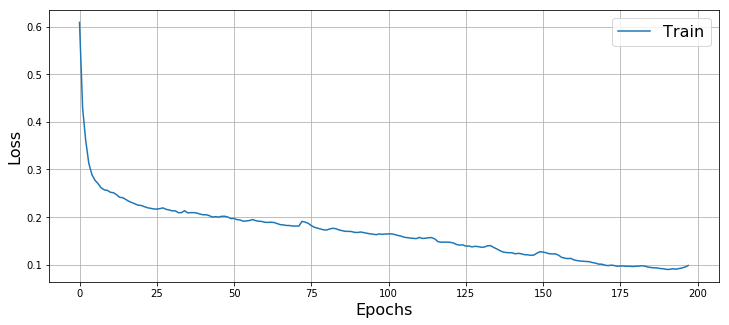

 99%|████████████████████████████████████████████████████████████████████████████▏| 198/200 [6:08:03<03:27, 103.91s/it]

Epoch 198... (Train/Test) MSE: 0.100/0.100


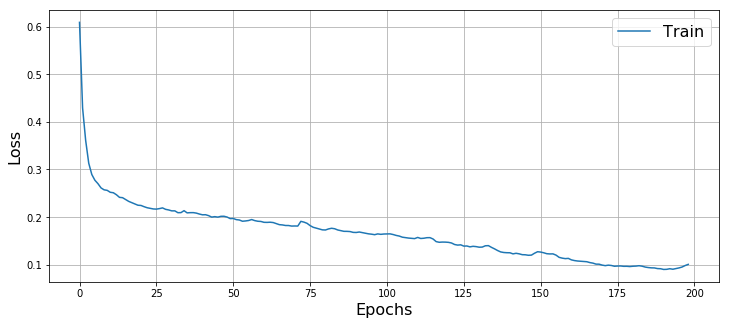

100%|████████████████████████████████████████████████████████████████████████████▌| 199/200 [6:09:47<01:43, 103.79s/it]

Epoch 199... (Train/Test) MSE: 0.101/0.101


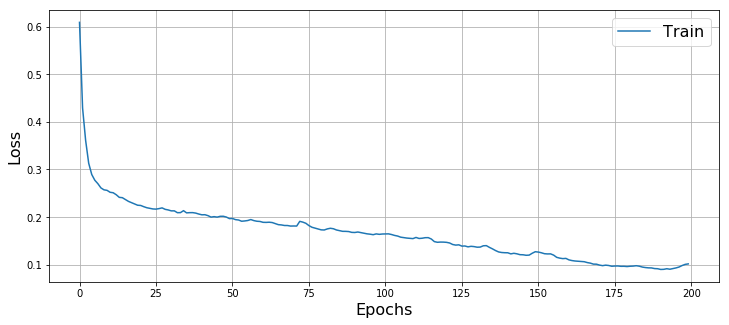

100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [6:11:30<00:00, 103.75s/it]


Wall time: 6h 11min 30s


In [21]:
NET=UNet(n_channels=3)
%time train(NET, 200, 0.001)

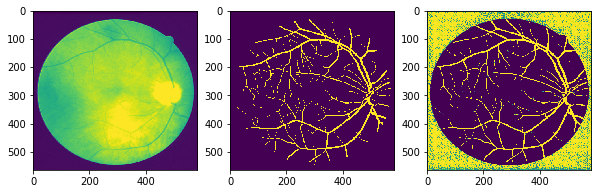

In [22]:
plt.figure(figsize=(10,10))
ax1=plt.subplot(1,3,1)
ax1.imshow(train_dataset[12][0].detach().numpy()[0])
ax2=plt.subplot(1,3,2)
ax2.imshow(train_dataset[12][1].detach().numpy()[0])
ax3=plt.subplot(1,3,3)
otv=NET(train_dataset[12][0].reshape(-1,3,565,584))
ax3.imshow(otv[0].detach().numpy()[0])

In [23]:
#os.makedirs("result")

import imageio
model = NET.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype('uint8')*255
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)
    #scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)
    
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


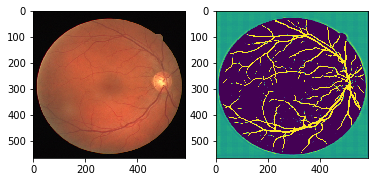

In [44]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)